
# IFT3395/6390 Devoir 3
## Rapport
> Professeur : Aaron Courville
>
> Étudiants: Zhibin Lu, Léa-Marie Normandin et Xiaocheng Liu


# Partie pratique (40 pts) : Implémentation du réseau de neurones

> On vous demande d’implémenter le réseau de neurones avec le calcul du gradient pas à pas tel que vous l’avez dérivé dans la question précédente (incluant le weight decay). Vous ne pouvez pas utiliser une implémentation existante de réseau de neurones, mais devez suivre la structure de la dérivation faite à la question 1 (avec des noms de variables s’en inspirant, etc.).
 

In [14]:
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

%pylab inline
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import time
import pickle
import gzip


Toggle Code

Populating the interactive namespace from numpy and matplotlib


## Des functions d'activation et softmax pour sortie, et function onehot

> Implémentation numériquement stable de softmax. Vous aurez besoin de pouvoir calculer un softmax de manière numériquement stable. Référez-vous aux materiaux supplémentaires pour de l’aide avec cela. Commencez par écrire le softmax d’un unique vecteur. Puis étendez votre code pour qu’il fonctionne aussi avec un mini-lot (min-batch) de plusieurs vecteurs stockés dans une matrice.

#### Réponse:
```
def onehots(Y, n):
    '''n: combien de classes. Retourner une matrice dont chaque rangee est un onehot'''
    targets = np.array(Y, dtype=int).reshape(-1)
    one_hots = np.eye(n)[targets]
    return one_hots

def softmax(Xs):
    '''pour la couche de sortie. Implementation numerique stable de softmax'''
    Bs=np.max(Xs, axis=0)
    return np.exp(Xs-Bs)/np.sum(np.exp(Xs-Bs), axis=0)

def rect(Xs):
    '''
    definir la fonction de ReLu/Ramp/Rectifieur et sa dérivee'''
    return np.maximum(0.0, Xs)
  
def rect_prime(Ys):
    '''
    définir la fonction de ReLu/Ramp/Rectifieur et sa prime'''
    return np.where(Ys > 0.0, 1.0, 0.0)

```

In [15]:

def onehots(Y, n):
    '''n: combien de classes. Retourner une matrice dont chaque rangee est un onehot'''
    targets = np.array(Y, dtype=int).reshape(-1)
    one_hots = np.eye(n)[targets]
    return one_hots

def softmax(Xs):
    '''pour la couche de sortie. Implementation numerique stable de softmax'''
    Bs=np.max(Xs, axis=0)
    return np.exp(Xs-Bs)/np.sum(np.exp(Xs-Bs), axis=0)

#def sigmoid(Xs):
#    '''definir le sigmoid reconnu'''
#    return 1.0/(1.0+np.exp(-Xs))

def rect(Xs):
    '''
    definir la fonction de ReLu/Ramp/Rectifieur et sa dérivee'''
    return np.maximum(0.0, Xs)
    
def rect_derivate(Ys):
    '''
    definir la fonction de ReLu/Ramp/Rectifieur et sa derivee'''
    return np.where(Ys > 0.0, 1.0, 0.0)

def rect_prime(Ys):
    '''
    définir la fonction de ReLu/Ramp/Rectifieur et sa prime'''
    return np.where(Ys > 0.0, 1.0, 0.0)

# plot une image avec matrice d'images
def plot_an_image(image):
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((28, 28)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))  
    plt.yticks(np.array([]))


## Manipulations : on utilisera les problèmes des deux lunes et le problème de classiﬁcation de chiﬀres manuscrits MNIST (voir liens sur la page du cours).

#### Réponse:
#### Prétraiter les données de MNIST et de 2 moons:

In [16]:
print 'Prétraiter les données de MNIST et de 2 moons:'
# Pour l'ensemble de donnees de mnist
f_mnist=gzip.open('mnist.pkl.gz')
f=gzip.open('mnist.pkl.gz')
mnistdata=pickle.load(f)
f.close()
mnist_train_inputs=mnistdata[0][0]
mnist_train_labels=mnistdata[0][1]
mnist_valid_inputs=mnistdata[1][0]
mnist_valid_lables=mnistdata[1][1]
mnist_test_inputs=mnistdata[2][0]
mnist_test_labels=mnistdata[2][1]
mnist_train_data = np.concatenate( (mnist_train_inputs, mnist_train_labels[:,None]) , axis=1 )
mnist_valid_data = np.concatenate( ( mnist_valid_inputs, mnist_valid_lables[:,None]) , axis=1 )
mnist_test_data = np.concatenate( (mnist_test_inputs , mnist_test_labels[:,None]) , axis=1 )

print 'mnist_train',mnist_train_data.shape
print 'mnist_valid',mnist_valid_data.shape
print 'mnist_test',mnist_test_data.shape

# Pour l'ensemble de donnees de 2moons
moons_data = np.loadtxt(open('2moons.txt','r'))
moons_train_cols = [0,1]
# L'indice de la colonne contenant les etiquettes
moons_target_ind = [moons_data.shape[1] - 1]
# Nombre de classes
moons_n_classes = 2
# Nombre de points d'entrainement
moons_n_train = 800
moons_n_valid = 200
moons_n_test = 100
# decommenter pour avoir des resultats non-deterministes
np.random.seed(3395)
# Determiner au hasard des indices pour les exemples d'entrainement et de test
inds = range(moons_data.shape[0])
np.random.shuffle(inds)
moons_train_inds = inds[:moons_n_train]
moons_valid_inds=inds[moons_n_train:moons_n_train+moons_n_valid]
moons_test_inds = inds[moons_n_train+moons_n_valid:]

# separer les donnees dans les deux ensembles
moons_train_data = moons_data[moons_train_inds,:]
moons_valid_data = moons_data[moons_valid_inds,:]
moons_test_data = moons_data[moons_test_inds,:]

# separer l'ensemble de test dans les entrees et les etiquettes
moons_test_inputs = moons_test_data[:,:-1]
moons_test_labels = moons_test_data[:,-1]

print 'moons_train',moons_train_data.shape
print 'moons_valid',moons_valid_data.shape
print 'moons_test',moons_test_data.shape

Prétraiter les données de MNIST et de 2 moons:
mnist_train (50000, 785)
mnist_valid (10000, 785)
mnist_test (10000, 785)
moons_train (800, 3)
moons_valid (200, 3)
moons_test (100, 3)


## Réponse: Nous implémentons une classe ReseauLoop  qui a seulement une couche cachée et qui fait la retro-propagation un exemple chaque fois, pour les questions 1, 2, 3, 4, 5.


## Initialisation des paramètres. 

> Comme vous le savez, il est nécessaire d’initialiser aléatoirement les paramètres du réseau (dans le but d’éviter les symétries et la saturation des neurones et idéalement pour se situer au point d’inﬂexion de la non-linéarité de façon à avoir un comportement non-linéaire). Nous vous proposons d’initialiser les poids d’une couche en les tirant d’une uniforme sur -1/√nc , 1/√nc, où nc est le nombre d’entrées de cette couche (le nombre de neurones d’entrée auxquels chaque neurone de cette couche est connecté, donc ça change typiquement d’une couche à l’autre). Les biais peuvent quant à eux être initialisés à 0. Justiﬁez votre choix de toute autre initialisation.

#### Réponse:
```
  self.b1 = np.zeros(self.sizes[1])[:,None]
  self.b2 = np.zeros(self.sizes[2])[:,None]
  self.w1 = np.random.uniform(-self.sizes[0]**-0.5,self.sizes[0]**-0.5,
               self.sizes[1]*self.sizes[0]).reshape(self.sizes[1],self.sizes[0])
  self.w2 = np.random.uniform(-self.sizes[1]**-0.5,self.sizes[1]**-0.5,
            self.sizes[2]*self.sizes[1]).reshape(self.sizes[2],self.sizes[1])
```

In [17]:

class ReseauLoop(object):
    
    def __init__(self, sizes, activationFunction, outputFunction):
        """
        # Le reseau neurone par loop (un exemple chaque fois)
        # accepter seulement un couche cachee
        # sizes = [2, 3, 2]=[couche entree,couche cache, couche sortie]
        #activationFunction: la fonction de activation
        #outputFunction: la fonction sortie
        """
        self.num_layers = len(sizes)
        if self.num_layers>3: 
            print 'Seulement une couche cachee pour ce modele de reseau!!!'
        else:
            self.sizes = sizes
            self.activationf = activationFunction
            self.outputf = outputFunction
        
        # On utilise vecteur colonne pour exprimer les biais de chaque couche 
        self.b1 = np.zeros(self.sizes[1])[:,None]
        self.b2 = np.zeros(self.sizes[2])[:,None]
        # sample the weights of a layer from a uniform distribution in -1/√nc , 1/√nc , 
        # where nc is the number of inputs for this layer
        self.w1 = np.random.uniform(-self.sizes[0]**-0.5,self.sizes[0]**-0.5,
                                    self.sizes[1]*self.sizes[0]).reshape(self.sizes[1],
                                                                         self.sizes[0])
        self.w2 = np.random.uniform(-self.sizes[1]**-0.5,self.sizes[1]**-0.5,
                                    self.sizes[2]*self.sizes[1]).reshape(self.sizes[2],
                                                                         self.sizes[1])

    # Xs(row) n'inclut pas de y
    def compute_predictions(self, Xs):
        OSs=[]
        for x in Xs:
            _,_,_,Os=self.fprop(x[:,None])
            OSs.append(Os.reshape(-1))
        return np.array(OSs)
        
    # forward propagation, un exemple par fois
    # x(col) n'inclut pas de y
    def fprop(self, x):
        # obtenir un vecteur, dimension=nombre de neurones de couche cachee.
        Ha=np.dot(self.w1, x) + self.b1
        # obtenir un vecteur apres la function d'activation, dimension=nombre de neurones de couche cachee
        Hs=self.activationf(Ha)
        # obtenir un vecteur, dimension=nombre de neurones de sorties
        Oa=np.dot(self.w2, Hs) + self.b2
        # vecteur de sortie, apres softmax, dimension=nombre de neurones de sorties
        Os=self.outputf(Oa)
        #print 'Os',Os
        return (Ha,Hs,Oa,Os)
        
    
    def bprop(self, x, mu, lambda1, lambda2): 
        '''
        # backward propagation
        # retro-propagation le reseau en utilisant une echantillon, 
        # et mise a jour des poids et des biais
        # x(row) inclut y
        # mu：taux d'apprentissage
        # lambda1 pour le  risque empirique r´egularis´e lambda1*||w||_1 pour chaque couche
        # lambda2 pour le  risque empirique r´egularis´e lambda2*||w||^2_2 pour chaque couche
        '''
        
        if len(x.shape)>1:
            print 'Une Exemple chaque fois!'
            return -1
        
        # pretraiter y en utilisant onehot
        if self.sizes[-1]>1:
            y=onehots( x[-1] , self.sizes[-1] ).T
        else:
            y=x[-1]
        x=x[:-1][:,None]
        
        # obtenir toutes les valeurs avant les neurones et tous les valeurs apres les 
        # neurones pour une echantillon
        Ha,Hs,Oa,Os=self.fprop(x)
        
        # la couche de sortie.
        Grad_Oa = Os - y
        # lambda1 pour le  risque empirique regularise lambda1*||w||_1 pour chaque couche
        # lambda2 pour le  risque empirique regularise lambda2*||w||^2_2 pour chaque couche
        regularizedGrad = lambda1*np.sign(self.w2) + 2*lambda2*self.w2
        #grad_w2, dimension: dimension de Os * dimension Hs(vecteur horizontal)
        Grad_W2=np.dot(Grad_Oa, Hs.T) + regularizedGrad
        #grad_b2 = grad_Oa, dimension= dimension de Oa
        Grad_B2=Grad_Oa
        # Grad_Hs= transforme de la martice de w2 dot vecteur de grad_Oa
        # dimension= nombre de neurone de couche cachee
        Grad_Hs= np.dot(self.w2.T, Grad_Oa)
        # obtenir la valeur de la derivation de la fonction d'activation
        derivation=eval(self.activationf.__name__+'_prime')(Ha)
        #derivation=eval(self.activationf.__name__+'_derivate')(HSs_layers[l])
        Grad_Ha=Grad_Hs * derivation
        regularizedGrad = lambda1*np.sign(self.w1) + 2*lambda2*self.w1
        #grad_w1, dimension: dimension de Ha(couche cachee) * dimension de x(vecteur horizontal)
        Grad_W1=np.dot(Grad_Ha, x.T) + regularizedGrad
        #grad_B1 = grad_Ha, dimension= dimension de Ha
        Grad_B1=Grad_Ha

        self.w1 -=  Grad_W1 * mu
        self.b1 -= Grad_B1 * mu 
        self.w2 -=  Grad_W2 * mu
        self.b2 -= Grad_B2 * mu 

    def loss(self, x):
        '''
        # calculer la valeur de la perte avec des thetas(w,s) courants de reseau
        # en utilisant la function J(theta)=-log(Os_Yeme(x))
        # x(row) inclut y
        '''
        
        if len(x.shape)>1:
            print 'Un exemple chaque fois!'
            return -1
        y=int(x[-1])
        x=x[:-1][:,None]
        #obtenir les valeurs de neurones de la sortie en donnant Xs d'echantillons
        Ha,Hs,Oa,Os=self.fprop(x)
        # calculer la perte en utilisant la function J(theta)=-log(Os_Yeme(x))
        if self.sizes[-1]>1:
            perte = -np.log(Os[y])
        else:
            Os=Os.reshape(-1)
            # quand la sortie est seulement un neurone
            perte = -y*np.log(Os) - (1 - y)*np.log(1 - Os)

        return perte


    def gradient_checking(self, x, id_w1, id_b1, id_w2, id_b2, epsilon, lambda1, lambda2):
        '''
        # Verification du gradient par difference finie.
        # Xs: une echantillon, row, inclut y
        # id_w, id_b: indiquer quels poids[couche,row(num de neurones de couche+1),col] 
        # et quel biais[couche,num de neurones de couche+1]
        # epsilon: entre 10e-6,10e-4
        # lambda1 pour le risque empirique regularise lambda1*||w||_1 pour chaque couche
        # lambda2 pour le risque empirique regularise lambda2*||w||^2_2 pour chaque couche
        '''
        w1o=np.copy(self.w1)
        b1o=np.copy(self.b1)
        w2o=np.copy(self.w2)
        b2o=np.copy(self.b2)
        # gradient_checking pour w1
        # sauvegarder le w et b precis.
        w_original=self.w1[id_w1[0],id_w1[1]]
        self.w1[id_w1[0],id_w1[1]]+=epsilon
        loss_plus=self.loss(x)
        self.w1[id_w1[0],id_w1[1]]-=2*epsilon
        loss_moins=self.loss(x)
        diff_finie= (loss_plus - loss_moins) / (epsilon * 2)
        self.w1[id_w1[0],id_w1[1]] = w_original
        #valeur du poids quand on utilise la methode de la descente du gradient
        self.bprop(x, mu=1, lambda1=lambda1, lambda2=lambda2)
        grad= w_original - self.w1[id_w1[0],id_w1[1]]
        # le ratio doit etre entre 0.99 et 1.01.
        #print 'loss_p:',loss_plus,'loss_m:',loss_moins,'diff:',diff_finie,'grad:',grad
        print 'diff_finie:',diff_finie,' grad w1',id_w1,':',grad, 'Ration diff_finie/grad:',diff_finie/grad
        self.w1=np.copy(w1o)
        self.b1= np.copy(b1o)
        self.w2= np.copy(w2o)
        self.b2= np.copy(b2o)
        
        # gradient_checking pour b1
        # sauvegarder le w et b precis.
        b_original=self.b1[id_b1][0]
        self.b1[id_b1][0]+=epsilon
        loss_plus=self.loss(x)
        self.b1[id_b1][0]-=2*epsilon
        loss_moins=self.loss(x)
        diff_finie= (loss_plus - loss_moins) / (epsilon * 2)
        self.b1[id_b1][0] = b_original
        #valeur de ce poids quand on utilise la methode de la descente du gradient
        self.bprop(x, mu=1, lambda1=lambda1, lambda2=lambda2)
        grad= b_original - self.b1[id_b1][0]
        # le ratio doit etre entre 0.99 et 1.01.
        #print 'loss_p',loss_plus,'loss_m',loss_moins,'diff',diff_finie,'grad',grad
        print 'diff_finie:',diff_finie,' grad b1',id_b1,':',grad, 'Ration diff_finie/grad:',diff_finie/grad
        self.w1=np.copy(w1o)
        self.b1= np.copy(b1o)
        self.w2= np.copy(w2o)
        self.b2= np.copy(b2o)
        
        # gradient_checking pour w2
        # sauvegarder le w et b precis.
        w_original=self.w2[id_w2[0],id_w2[1]]
        self.w2[id_w2[0],id_w2[1]]+=epsilon
        loss_plus=self.loss(x)
        self.w2[id_w2[0],id_w2[1]]-=2*epsilon
        loss_moins=self.loss(x)
        diff_finie= (loss_plus - loss_moins) / (epsilon * 2)
        self.w2[id_w2[0],id_w2[1]] = w_original
        #valeur de ce poids quand on utilise la methode de la descente du gradient
        self.bprop(x, mu=1, lambda1=lambda1, lambda2=lambda2)
        grad= w_original - self.w2[id_w2[0],id_w2[1]]
        # le ratio doit etre entre 0.99 et 1.01.
        #print 'loss_p',loss_plus,'loss_m',loss_moins,'diff',diff_finie,'grad',grad
        print 'diff_finie:',diff_finie,' grad w2',id_w2,':',grad, 'Ration diff_finie/grad:',diff_finie/grad
        self.w1=np.copy(w1o)
        self.b1= np.copy(b1o)
        self.w2= np.copy(w2o)
        self.b2= np.copy(b2o)
        
        # gradient_checking pour b2
        # sauvegarder le w et b precis.
        b_original=self.b2[id_b2][0]
        self.b2[id_b2][0]+=epsilon
        loss_plus=self.loss(x)
        self.b2[id_b2][0]-=2*epsilon
        loss_moins=self.loss(x)
        diff_finie= (loss_plus - loss_moins) / (epsilon * 2)
        self.b2[id_b2][0] = b_original
        #valeur de ce poids quand on utilise la methode de la descente du gradient
        self.bprop(x, mu=1, lambda1=lambda1, lambda2=lambda2)
        grad= b_original - self.b2[id_b2][0]
        # le ratio doit etre entre 0.99 et 1.01.
        #print 'loss_p',loss_plus,'loss_m',loss_moins,'diff',diff_finie,'grad',grad
        print 'diff_finie:',diff_finie,' grad b2',id_b2,':',grad, 'Ration diff_finie/grad:',diff_finie/grad
        self.w1=np.copy(w1o)
        self.b1= np.copy(b1o)
        self.w2= np.copy(w2o)
        self.b2= np.copy(b2o)
        
    
    def loss_minibatch(self, Xs):
        '''
        # calculer la valeur de la perte avec des thetas(w,s) courants de reseau
        # en utilisant la function J(theta)=-log(Os_Yeme(x))
        # Xs(row) inclut Ys
        '''
        
        k = len(Xs)
        Ys=np.array(Xs[:,-1], dtype=int)
        #obtenir les valeurs de neurones de la sortie en donnant les x de l'échantillon
        Os=self.compute_predictions(Xs=Xs[:,:-1]).T
        # calculer la perte en utilisant la function J(theta)=-log(Os_Yeme(x))
        if self.sizes[-1]>1:
            perte = np.array([-np.log(o[y]) for o,y in zip(Os.T,Ys)]).sum() / k
        else:
            Os=Os.reshape(-1)
            # quand la sortie est seulement un neurone
            perte = ( -np.dot(Ys, np.log(Os).T) - np.dot((1 - Ys), np.log(1 - Os).T) ) / k

        return perte

    def gradient_checking_minibatch(self, Xs, id_w1, id_b1, id_w2, id_b2 , 
                                    epsilon, lambda1, lambda2):
        '''
        # Verification du gradient par difference finie.
        # Xs(row): les echantillons
        # id_w, id_b: indiquer quel poids[couche,row(num de neurones de couche+1),col] 
        # et quel biais[couche,num de neurones de couche+1]
        # epsilon: entre 10e-6,10e-4
        # lambda1 pour le  risque empirique regularise lambda1*||w||_1 pour chaque couche
        # lambda2 pour le  risque empirique regularise lambda2*||w||^2_2 pour chaque couche
        '''
        
        w1o=np.copy(self.w1)
        b1o=np.copy(self.b1)
        w2o=np.copy(self.w2)
        b2o=np.copy(self.b2)
        # gradient_checking pour w1
        # sauvegarder le w et b precis.
        w_original=self.w1[id_w1[0],id_w1[1]]
        self.w1[id_w1[0],id_w1[1]]+=epsilon
        loss_plus=self.loss_minibatch(Xs)
        print 'loss_plus',loss_plus
        self.w1[id_w1[0],id_w1[1]]-=2*epsilon
        loss_moins=self.loss_minibatch(Xs)
        print 'loss_moins',loss_moins
        diff_finie= (loss_plus - loss_moins) / (epsilon * 2)
        self.w1[id_w1[0],id_w1[1]] = w_original
        #valeur de ce poids quand on utilise la methode de la descente du gradient
        self.bprop_minibatch(Xs, mu=1, lambda1=lambda1, lambda2=lambda2)
        grad= w_original - self.w1[id_w1[0],id_w1[1]]
        # le ratio doit etre entre 0.99 et 1.01.
        #print 'loss_p:',loss_plus,'loss_m:',loss_moins,'diff:',diff_finie,'grad:',grad
        print 'K=',len(Xs),' diff_finie:',diff_finie,', grad w1',id_w1,':',grad, 'Ration diff_finie/grad:',diff_finie/grad
        self.w1=np.copy(w1o)
        self.b1= np.copy(b1o)
        self.w2= np.copy(w2o)
        self.b2= np.copy(b2o)
        
        # gradient_checking pour b1
        # sauvegarder le w et b precis.
        b_original=self.b1[id_b1][0]
        self.b1[id_b1][0]+=epsilon
        loss_plus=self.loss_minibatch(Xs)
        self.b1[id_b1][0]-=2*epsilon
        loss_moins=self.loss_minibatch(Xs)
        diff_finie= (loss_plus - loss_moins) / (epsilon * 2)
        self.b1[id_b1][0] = b_original
        #valeur de ce poids quand on utilise la methode de la descente du gradientt
        self.bprop_minibatch(Xs, mu=1, lambda1=lambda1, lambda2=lambda2)
        grad= b_original - self.b1[id_b1][0]
        # le ratio doit etre entre 0.99 et 1.01.
        #print 'loss_p',loss_plus,'loss_m',loss_moins,'diff',diff_finie,'grad',grad
        print 'K=',len(Xs),' diff_finie:',diff_finie,', grad b1',id_b1,':',grad, 'Ration diff_finie/grad:',diff_finie/grad
        self.w1=np.copy(w1o)
        self.b1= np.copy(b1o)
        self.w2= np.copy(w2o)
        self.b2= np.copy(b2o)
        
        # gradient_checking pour w2
        # sauvegarder le w et b precis.
        w_original=self.w2[id_w2[0],id_w2[1]]
        self.w2[id_w2[0],id_w2[1]]+=epsilon
        loss_plus=self.loss_minibatch(Xs)
        self.w2[id_w2[0],id_w2[1]]-=2*epsilon
        loss_moins=self.loss_minibatch(Xs)
        diff_finie= (loss_plus - loss_moins) / (epsilon * 2)
        self.w2[id_w2[0],id_w2[1]] = w_original
        #valeur de ce poids quand on utilise la methode de la descente du gradient
        self.bprop_minibatch(Xs, mu=1, lambda1=lambda1, lambda2=lambda2)
        grad= w_original - self.w2[id_w2[0],id_w2[1]]
        # le ratio doit etre entre 0.99 et 1.01.
        #print 'loss_p',loss_plus,'loss_m',loss_moins,'diff',diff_finie,'grad',grad
        print 'K=',len(Xs),' diff_finie:',diff_finie,', grad w2',id_w2,':',grad, 'Ration diff_finie/grad:',diff_finie/grad
        self.w1=np.copy(w1o)
        self.b1= np.copy(b1o)
        self.w2= np.copy(w2o)
        self.b2= np.copy(b2o)
        
        # gradient_checking pour b2
        # sauvegarder le w et b precis.
        b_original=self.b2[id_b2][0]
        self.b2[id_b2][0]+=epsilon
        loss_plus=self.loss_minibatch(Xs)
        self.b2[id_b2][0]-=2*epsilon
        loss_moins=self.loss_minibatch(Xs)
        diff_finie= (loss_plus - loss_moins) / (epsilon * 2)
        self.b2[id_b2][0] = b_original
        #valeur de ce poids quand on utilise la methode de la descente du gradient
        self.bprop_minibatch(Xs, mu=1, lambda1=lambda1, lambda2=lambda2)
        grad= b_original - self.b2[id_b2][0]
        # le ratio doit etre entre 0.99 et 1.01.
        #print 'loss_p',loss_plus,'loss_m',loss_moins,'diff',diff_finie,'grad',grad
        print 'K=',len(Xs),' diff_finie:',diff_finie,', grad b2',id_b2,':',grad, 'Ration diff_finie/grad:',diff_finie/grad
        self.w1=np.copy(w1o)
        self.b1= np.copy(b1o)
        self.w2= np.copy(w2o)
        self.b2= np.copy(b2o)
    
    def bprop_minibatch(self, mini_data, mu, lambda1, lambda2): 
        '''
        # backward propagation
        # retro-propagation le reseau en utilisant mini_data(echantillons), 
        # et mise a jour les poids et les biais
        # mini_data(row) inclut ys
        # mu：taux d'apprentissage
        # lambda1 pour le  risque empirique r´egularis´e lambda1*||w||_1 pour chaque couche
        # lambda2 pour le  risque empirique r´egularis´e lambda2*||w||^2_2 pour chaque couche
        '''
        Grad_W1=np.zeros(self.w1.shape)
        Grad_B1=np.zeros(self.b1.shape)
        Grad_W2=np.zeros(self.w2.shape)
        Grad_B2=np.zeros(self.b2.shape)
        
        k=len(mini_data)
        for x in mini_data:
            # pretraiter y en utilisant onehot
            if self.sizes[-1]>1:
                y=onehots( x[-1] , self.sizes[-1] ).T
            else:
                y=x[-1]
            x=x[:-1][:,None]

            # obtenir toutes les values avant les neurones et toutes les valeurs 
            # apres les neurones pour une echantillons
            Ha,Hs,Oa,Os=self.fprop(x)

            # la couche de sortie.
            #faire la retro-propagation a partir de la 2eme couche a l'inverse.
            Grad_Oa = Os - y
            # lambda pour le risque empirique regularise lambda2*||w||^2_2 pour chaque couche
            R2 =lambda1*np.sign(self.w2) + 2*lambda2*self.w2
            # sum de grad_W2, pour k mini batch.
            # dimension:Dimension de Os(vecteur de couche sortie) * dimension Hs(vecteur horizontal)
            Grad_W2+=np.dot(Grad_Oa, Hs.T) +R2
            # sum de Grad_B2, pour k mini batch, grad_b = grad_Oa, dimension= dimension de Oa
            Grad_B2+=Grad_Oa
            # Grad_Hs= transforme de la martice de w2 dot vecteur de grad_Oa
            # dimension= nombre de neurone de couche cachee
            Grad_Hs= np.dot(self.w2.T, Grad_Oa)
            # obtenir la valeur de la derivation de la fonction d'activation
            derivation=eval(self.activationf.__name__+'_prime')(Ha)
            # derivation=eval(self.activationf.__name__+'_derivate')(HSs_layers[l])
            Grad_Ha=Grad_Hs * derivation
            # lambda pour le risque empirique regularise lambda2*||w||^2_2 pour chaque couche
            R1 =lambda1*np.sign(self.w1) + 2*lambda2*self.w1
            # sum de grad_W1, pour k mini batch.
            # Dimension de Ha(vecteur de couche cachee) * dimension de x(vecteur horizontal)
            Grad_W1+=np.dot(Grad_Ha, x.T) + R1
            #sum de Grad_B1, pour k mini batch. grad_B1 = grad_Ha, dimension= dimension de Ha
            Grad_B1+=Grad_Ha

        self.w1 -=  Grad_W1 * mu / k
        self.b1 -= Grad_B1 * mu / k
        self.w2 -=  Grad_W2 * mu / k
        self.b2 -= Grad_B2 * mu / k

    def gradiantDescentMiniBatch(self, training_data, epoque, K_mini_batch_size, mu,
            lambda1, lambda2, validation_data=None, test_data=None):
        """
        # la methode de la descente du gradient pour minibatch, 
        # mais realiser par loop (un exemple une fois)
        # training_data: l'ensemble de donnees d'entrainement
        # epoque: la fois d'entrainement
        # K_mini_batch_szie:la taille de data pour chaque fois d'entrainement
        # mu: taux d'apprentissage
        # lambda: taux de regularisation
        # validation_data, test_data
        """
        n = len(training_data)
        for ep in xrange(epoque):
            # diviser training data selon la taille de mini_batch
            mini_batches = [
                training_data[k:k+K_mini_batch_size]
                for k in xrange(0, n, K_mini_batch_size)]
            for mini_data in mini_batches:
                # mise a jour  w et b un fois selon un petit ensemble d'entrainement de donnees
                self.bprop_minibatch(mini_data, mu, lambda1, lambda2)

            # faire la validation
            if validation_data is not None:
                taux,err,loss=self.evaluate(validation_data)
                print "Epoque {0} fini: {1} erreurs sur {2} validation data, Taux d'erreur: {3}, Loss: {4}".format(
                        ep, err , len(validation_data), taux, loss )
                    
            # faire le test
            if test_data is not None:
                taux,err,loss=self.evaluate(test_data)
                print "Epoque {0} fini: {1} erreurs sur {2} test data, Taux d'erreur: {3}, Loss: {4}".format(
                        ep, err , len(test_data), taux, loss )

    def evaluate(self, test_data):
        '''
        # return taux d'erreur,num d'erreur, loss pour test_data 
        # quand on fait chaque descente de gradient.
        # test_data: row, inclut y
        # numero de neurone de sortie>=2
        '''
        classes_pred=np.argmax(self.compute_predictions(test_data[:,:-1]), axis=1)
        err= test_data[:,-1]!=classes_pred
        n_err=classes_pred[err].size
        taux=float(n_err)/float(len(test_data))
        return ( taux, n_err, self.loss_minibatch(test_data) )
    
    def evaluateAccuracy(self, test_data):
        '''
        # afficher le numero de prediction correct pour test_data 
        # quand on fait chaque descente de gradient.
        # numero de neurone de sortie>=2
        '''
        classes_pred=np.argmax(self.compute_predictions(test_data[:,:-1]), axis=1)
        correct= test_data[:,-1]==classes_pred
        return classes_pred[correct].size
        

#test
#rn1=ReseauLoop([2,3,2],rect,softmax)
#test=np.array([[-1,2],[2,3]])
#print test
#print rn1.compute_predictions(test)


## Question 1:
> 1.Dans un premier temps, commencez par une implémentation qui calcule le gradient pour un exemple, et vériﬁez que le calcul est correct avec la technique de vériﬁcation du gradient par diﬀérence ﬁnie expliquée ci-dessus.

#### Réponse:

In [23]:
# parfois grad=0, il faut rouler le code quelques fois.
rn=ReseauLoop([2,2,2],rect,softmax)
unExemple=np.array([moons_test_data[0]][0])
print 'exemple:',unExemple
# choisir 4 thetas pour test le gradient_checking
id_w1=[0,0]
id_b1=0
id_w2=[1,1]
id_b2=1
# parfois grad=0, il faut rouler le code quelques fois.
rn.gradient_checking(unExemple, id_w1,id_b1,id_w2,id_b2, 
                     epsilon=0.0001,lambda1=0.00001,lambda2=0.00001)


exemple: [-0.515599  0.865439  0.      ]
diff_finie: [ 0.0042942]  grad w1 [0, 0] : 0.00427402020115 Ration diff_finie/grad: [ 1.00472057]
diff_finie: [-0.00832856]  grad b1 0 : -0.00832855771394 Ration diff_finie/grad: [ 1.]
diff_finie: [ 0.04437342]  grad w2 [1, 1] : 0.0443899422816 Ration diff_finie/grad: [ 0.99962789]
diff_finie: [ 0.49651986]  grad b2 1 : 0.496519860532 Ration diff_finie/grad: [ 1.]


## Question 2:
> 2.Vériﬁcation du gradient : produire un affchage de vériﬁcation du gradient par diﬀérence ﬁnie pour votre réseau (pour un petit réseau, par ex. d = 2 et dh = 2 initialisé aléatoirement) sur l'exemple.

#### Réponse:

In [43]:
unExemple=np.array([moons_test_data[0]][0])
print 'exemple:',unExemple
# choisir 4 thetas pour test le gradient_checking
id_w1=[0,0]
id_b1=0
id_w2=[1,1]
id_b2=1

rn=ReseauLoop([2,2,2],rect,softmax)
rn.gradient_checking(unExemple, id_w1,id_b1,id_w2,id_b2, 
                     epsilon=0.001,lambda1=0.00001,lambda2=0.00001)

rn=ReseauLoop([2,2,2],rect,softmax)
rn.gradient_checking(unExemple, id_w1,id_b1,id_w2,id_b2, 
                     epsilon=0.0001,lambda1=0.00001,lambda2=0.00001)

rn=ReseauLoop([2,2,2],rect,softmax)
rn.gradient_checking(unExemple, id_w1,id_b1,id_w2,id_b2, 
                     epsilon=0.00001,lambda1=0.00001,lambda2=0.00001)


exemple: [-0.515599  0.865439  0.      ]
diff_finie: [-0.40923455]  grad w1 [0, 0] : -0.409246567607 Ration diff_finie/grad: [ 0.99997063]
diff_finie: [ 0.79370701]  grad b1 0 : 0.793707029629 Ration diff_finie/grad: [ 0.99999998]
diff_finie: [ 0.]  grad w2 [1, 1] : 1.01296931182e-05 Ration diff_finie/grad: [ 0.]
diff_finie: [ 0.59765666]  grad b2 1 : 0.597656667442 Ration diff_finie/grad: [ 0.99999999]
diff_finie: [ 0.]  grad w1 [0, 0] : 1.29733739414e-05 Ration diff_finie/grad: [ 0.]
diff_finie: [ 0.]  grad b1 0 : 0.0 Ration diff_finie/grad: [ nan]
diff_finie: [ 0.12643924]  grad w2 [1, 1] : 0.126425178171 Ration diff_finie/grad: [ 1.00011125]
diff_finie: [ 0.44044397]  grad b2 1 : 0.440443966744 Ration diff_finie/grad: [ 1.]
diff_finie: [-0.11712942]  grad w1 [0, 0] : -0.117116773636 Ration diff_finie/grad: [ 1.00010799]
diff_finie: [ 0.22717154]  grad b1 0 : 0.227171543344 Ration diff_finie/grad: [ 1.]
diff_finie: [ 0.03317565]  grad w2 [1, 1] : 0.0331897307351 Ration diff_finie/gr

/Users/louis/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: invalid value encountered in divide


## Question 3:
> 3.Ajoutez à cette version un hyperparamètre de taille de lot K, pour permettre le calcul du gradient par mini-lot de K exemples (présentés sous forme de matrices), en faisant une boucle sur les K exemples (c’est une petit ajout à votre code précédent).

#### Réponse: voir la code de la  function bprop_minibatch et gradient_checking_minibatch dans ReseauLoop


## Question 4:
> 4.Vériﬁcation du gradient : produire un affichage de vériﬁcation du gradient sur les paramètres, par diﬀérence ﬁnie pour votre réseau (pour un petit réseau, par ex. d = 2 et dh = 2 initialisé aléatoirement) pour un lot de 10 exemples (vous pouvez prendre des exemples des deux classes du jeux de données des 2 lunes).

#### Réponse:

In [45]:
data=moons_test_data[0:10]
# choisir 4 thetas pour test le gradient_checking_minibatch
id_w1=[0,0]
id_b1=0
id_w2=[1,1]
id_b2=1
# seulement marche 1 fois, car quand il fait la descente du gradient, mu=1
rn = ReseauLoop([2, 2, 2],rect,softmax)
rn.gradient_checking_minibatch(data, id_w1, id_b1, id_w2, id_b2, epsilon=0.001,lambda1=0.00001,lambda2=0.00002)
rn = ReseauLoop([2, 2, 2],rect,softmax)
rn.gradient_checking_minibatch(data, id_w1, id_b1, id_w2, id_b2, epsilon=0.0001,lambda1=0.00001,lambda2=0.00002)
rn = ReseauLoop([2, 2, 2],rect,softmax)
rn.gradient_checking_minibatch(data, id_w1, id_b1, id_w2, id_b2, epsilon=0.00001,lambda1=0.00001,lambda2=0.00002)


loss_plus 0.693768650974
loss_moins 0.693647260254
K= 10  diff_finie: 0.0606953598442 , grad w1 [0, 0] : 0.0606668899367 Ration diff_finie/grad: 1.00046928246
K= 10  diff_finie: -0.0213035599415 , grad b1 0 : -0.0213035598031 Ration diff_finie/grad: 1.00000000649
K= 10  diff_finie: 0.046397483993 , grad w2 [1, 1] : 0.0463741505059 Ration diff_finie/grad: 1.00050315719
K= 10  diff_finie: 0.142034294902 , grad b2 1 : 0.142034298161 Ration diff_finie/grad: 0.999999977055
loss_plus 0.714866151075
loss_moins 0.71483436261
K= 10  diff_finie: 0.158942322482 , grad w1 [0, 0] : 0.158973473122 Ration diff_finie/grad: 0.999804051333
K= 10  diff_finie: 0.143464782775 , grad b1 0 : 0.143464782783 Ration diff_finie/grad: 0.999999999943
K= 10  diff_finie: 0.0521754857258 , grad w2 [1, 1] : 0.0521373583325 Ration diff_finie/grad: 1.0007312874
K= 10  diff_finie: 0.114004069493 , grad b2 1 : 0.114004069505 Ration diff_finie/grad: 0.999999999894
loss_plus 0.652811566746
loss_moins 0.652811913924
K= 10  d

## Question 5:
> 5.Entrainer votre réseau de neurones par descente de gradient sur les données du problème des deux-lunes. Aﬃcher les régions de décision pour diﬀérentes valeurs d’hyper-paramètres (weight decay, nombre d’unites cachées, arrêt prématuré) de façon à illustrer leur eﬀet sur le contrôle de capacité.

#### Réponse:
#### On va essayer quelques valeurs d'hyper-paramètres, comme mu(ratio d'apprentissage), numéro de neurones cachés, lambda de régularisation, époque d'entrainement, K(taille de minidata pour la descente du gradient)

#### Exemple 1:

les hyper-parameter:

reseauSizes=[2, 2, 2]

mu = 0.1

epoque=10

K_minibatch=5

lambda1=0.0002

lambda2=0.0004

Epoque 0 fini: 37 erreurs sur 200 validation data, Taux d'erreur: 0.185, Loss: 0.423630770968
Epoque 1 fini: 38 erreurs sur 200 validation data, Taux d'erreur: 0.19, Loss: 0.41932357544
Epoque 2 fini: 38 erreurs sur 200 validation data, Taux d'erreur: 0.19, Loss: 0.420324131524
Epoque 3 fini: 37 erreurs sur 200 validation data, Taux d'erreur: 0.185, Loss: 0.42150206537
Epoque 4 fini: 38 erreurs sur 200 validation data, Taux d'erreur: 0.19, Loss: 0.425394221112
Epoque 5 fini: 40 erreurs sur 200 validation data, Taux d'erreur: 0.2, Loss: 0.425102258477
Epoque 6 fini: 41 erreurs sur 200 validation data, Taux d'erreur: 0.205, Loss: 0.426533585667
Epoque 7 fini: 41 erreurs sur 200 validation data, Taux d'erreur: 0.205, Loss: 0.426939318101
Epoque 8 fini: 43 erreurs sur 200 validation data, Taux d'erreur: 0.215, Loss: 0.428008138499
Epoque 9 fini: 43 erreurs sur 200 validation data, Taux d'erreur: 0.215, Loss: 0.429464245008
Ca nous a pris  0.709735  secondes pour entrainer le reseau [2, 2, 

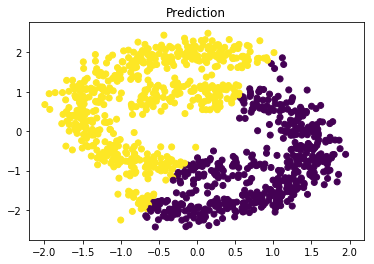

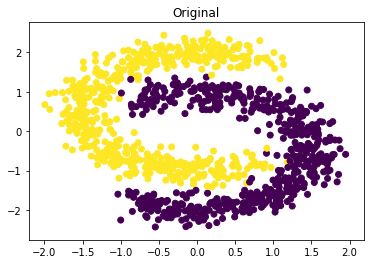

In [46]:
# definir les hyper-parametres
reseauSizes=[2, 2, 2]
mu = 0.1
epoque=10
K_minibatch=5
lambda1=0.0002
lambda2=0.0004
# Faire l'entrainement
t1 = time.clock()
rn = ReseauLoop(reseauSizes,rect,softmax) 
rn.gradiantDescentMiniBatch(moons_train_data, epoque, K_minibatch, mu, lambda1, lambda2, moons_valid_data)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour entrainer le reseau',rn.sizes,' sur ', moons_train_data.shape[0],' points de training data et ',moons_valid_data.shape[0],' points de validation data.'

# Faire les tests
t1 = time.clock()
classes_pred=rn.compute_predictions(moons_test_inputs)
classes_pred=np.argmax(rn.compute_predictions(moons_test_inputs),axis=1)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour calculer les predictions sur ', moons_test_inputs.shape[0],' points de test'
err = 1.0 - np.mean(moons_test_labels==classes_pred)
print "L'erreur de test est de ", 100.0 * err,"%"

if len(moons_train_cols) == 2:
    # Surface de decision
    # Predire
    train_classes_pred=rn.compute_predictions(moons_train_data[:,:-1])
    train_classes_pred=np.argmax(train_classes_pred,axis=1)
    valid_classes_pred=rn.compute_predictions(moons_valid_data[:,:-1])
    valid_classes_pred=np.argmax(valid_classes_pred,axis=1)
    
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=train_classes_pred)
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=valid_classes_pred)
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=classes_pred)
    plt.title('Prediction')
    plt.show()

    # data original
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=moons_train_data[:,-1])
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=moons_valid_data[:,-1])
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=moons_test_labels)
    plt.title('Original')
    plt.show()
    
else:
    print 'Trop de dimensions (', len(moons_train_cols),') pour pouvoir afficher la surface de decision'


#### Exemple 2:

reseauSizes=[2, 2, 2]

mu = 0.2 #change

epoque=30 #change

K_minibatch=30 #change

lambda1=0.0002

lambda2=0.0004

Epoque 0 fini: 40 erreurs sur 200 validation data, Taux d'erreur: 0.2, Loss: 0.555720752035
Epoque 1 fini: 39 erreurs sur 200 validation data, Taux d'erreur: 0.195, Loss: 0.476023611544
Epoque 2 fini: 39 erreurs sur 200 validation data, Taux d'erreur: 0.195, Loss: 0.458986438016
Epoque 3 fini: 39 erreurs sur 200 validation data, Taux d'erreur: 0.195, Loss: 0.453500336045
Epoque 4 fini: 39 erreurs sur 200 validation data, Taux d'erreur: 0.195, Loss: 0.450913690186
Epoque 5 fini: 38 erreurs sur 200 validation data, Taux d'erreur: 0.19, Loss: 0.446584635318
Epoque 6 fini: 37 erreurs sur 200 validation data, Taux d'erreur: 0.185, Loss: 0.438537010864
Epoque 7 fini: 37 erreurs sur 200 validation data, Taux d'erreur: 0.185, Loss: 0.4337002501
Epoque 8 fini: 37 erreurs sur 200 validation data, Taux d'erreur: 0.185, Loss: 0.427320992211
Epoque 9 fini: 37 erreurs sur 200 validation data, Taux d'erreur: 0.185, Loss: 0.419031799609
Epoque 10 fini: 37 erreurs sur 200 validation data, Taux d'erreur

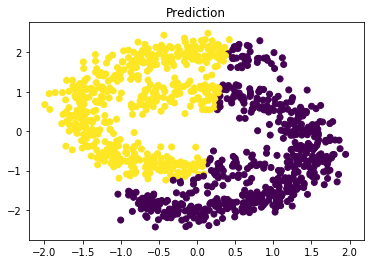

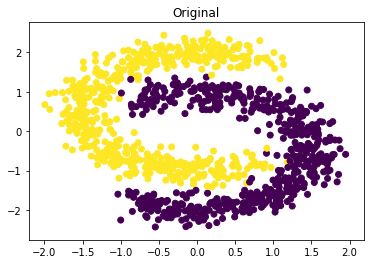

In [47]:
# definir les hyper-parametres
reseauSizes=[2, 2, 2]
mu = 0.2 #change
epoque=30 #change
K_minibatch=30 #change
lambda1=0.0002
lambda2=0.0004
# Faire l'entrainement
t1 = time.clock()
rn = ReseauLoop(reseauSizes,rect,softmax) 
rn.gradiantDescentMiniBatch(moons_train_data, epoque, K_minibatch, mu, lambda1, lambda2, moons_valid_data)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour entrainer le reseau',rn.sizes,' sur ', moons_train_data.shape[0],' points de training data et ',moons_valid_data.shape[0],' points de validation data.'

# Faire les tests
t1 = time.clock()
classes_pred=rn.compute_predictions(moons_test_inputs)
classes_pred=np.argmax(rn.compute_predictions(moons_test_inputs),axis=1)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour calculer les predictions sur ', moons_test_inputs.shape[0],' points de test'
err = 1.0 - np.mean(moons_test_labels==classes_pred)
print "L'erreur de test est de ", 100.0 * err,"%"

if len(moons_train_cols) == 2:
    # Surface de decision
    # Predire
    train_classes_pred=rn.compute_predictions(moons_train_data[:,:-1])
    train_classes_pred=np.argmax(train_classes_pred,axis=1)
    valid_classes_pred=rn.compute_predictions(moons_valid_data[:,:-1])
    valid_classes_pred=np.argmax(valid_classes_pred,axis=1)
    
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=train_classes_pred)
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=valid_classes_pred)
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=classes_pred)
    plt.title('Prediction')
    plt.show()

    # data original
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=moons_train_data[:,-1])
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=moons_valid_data[:,-1])
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=moons_test_labels)
    plt.title('Original')
    plt.show()
    
else:
    print 'Trop de dimensions (', len(moons_train_cols),') pour pouvoir afficher la surface de decision'


#### Exemple 3:

reseauSizes=[2, 3, 2] #change

mu = 0.42

epoque=10

K_minibatch=15 

lambda1=0.00001

lambda2=0.00002

Epoque 0 fini: 37 erreurs sur 200 validation data, Taux d'erreur: 0.185, Loss: 0.434466995145
Epoque 1 fini: 36 erreurs sur 200 validation data, Taux d'erreur: 0.18, Loss: 0.398362427943
Epoque 2 fini: 34 erreurs sur 200 validation data, Taux d'erreur: 0.17, Loss: 0.357709294079
Epoque 3 fini: 34 erreurs sur 200 validation data, Taux d'erreur: 0.17, Loss: 0.332310277319
Epoque 4 fini: 31 erreurs sur 200 validation data, Taux d'erreur: 0.155, Loss: 0.308556768266
Epoque 5 fini: 30 erreurs sur 200 validation data, Taux d'erreur: 0.15, Loss: 0.286294998427
Epoque 6 fini: 30 erreurs sur 200 validation data, Taux d'erreur: 0.15, Loss: 0.274584797235
Epoque 7 fini: 28 erreurs sur 200 validation data, Taux d'erreur: 0.14, Loss: 0.268561171083
Epoque 8 fini: 25 erreurs sur 200 validation data, Taux d'erreur: 0.125, Loss: 0.26501402744
Epoque 9 fini: 25 erreurs sur 200 validation data, Taux d'erreur: 0.125, Loss: 0.263473829523
Ca nous a pris  0.745639000001  secondes pour entrainer le reseau [

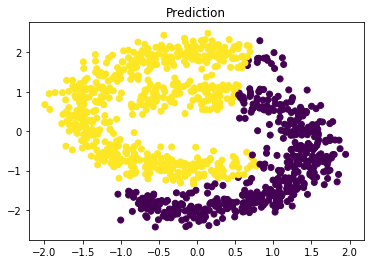

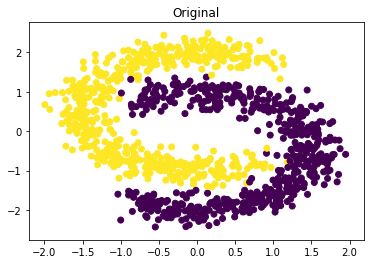

In [602]:
# definir les hyper-parametres
reseauSizes=[2, 3, 2] #change
mu = 0.42
epoque=10
K_minibatch=15 
lambda1=0.00001
lambda2=0.00002
# Faire l'entrainement
t1 = time.clock()
rn = ReseauLoop(reseauSizes,rect,softmax) 
rn.gradiantDescentMiniBatch(moons_train_data, epoque, K_minibatch, mu, lambda1, lambda2, moons_valid_data)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour entrainer le reseau',rn.sizes,' sur ', moons_train_data.shape[0],' points de training data et ',moons_valid_data.shape[0],' points de validation data.'

# Faire les tests
t1 = time.clock()
classes_pred=rn.compute_predictions(moons_test_inputs)
classes_pred=np.argmax(rn.compute_predictions(moons_test_inputs),axis=1)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour calculer les predictions sur ', moons_test_inputs.shape[0],' points de test'
err = 1.0 - np.mean(moons_test_labels==classes_pred)
print "L'erreur de test est de ", 100.0 * err,"%"

if len(moons_train_cols) == 2:
    # Surface de decision
    # Predire
    train_classes_pred=rn.compute_predictions(moons_train_data[:,:-1])
    train_classes_pred=np.argmax(train_classes_pred,axis=1)
    valid_classes_pred=rn.compute_predictions(moons_valid_data[:,:-1])
    valid_classes_pred=np.argmax(valid_classes_pred,axis=1)
    
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=train_classes_pred)
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=valid_classes_pred)
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=classes_pred)
    plt.title('Prediction')
    plt.show()

    # data original
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=moons_train_data[:,-1])
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=moons_valid_data[:,-1])
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=moons_test_labels)
    plt.title('Original')
    plt.show()
    
else:
    print 'Trop de dimensions (', len(moons_train_cols),') pour pouvoir afficher la surface de decision'


#### Exemple 4:

reseauSizes=[2, 3, 2]

mu = 0.39

epoque=30

K_minibatch=10

lambda1=0.00001

lambda2=0.00002

Epoque 0 fini: 33 erreurs sur 200 validation data, Taux d'erreur: 0.165, Loss: 0.41613864774
Epoque 1 fini: 32 erreurs sur 200 validation data, Taux d'erreur: 0.16, Loss: 0.38594587238
Epoque 2 fini: 29 erreurs sur 200 validation data, Taux d'erreur: 0.145, Loss: 0.351302288803
Epoque 3 fini: 26 erreurs sur 200 validation data, Taux d'erreur: 0.13, Loss: 0.311235038381
Epoque 4 fini: 25 erreurs sur 200 validation data, Taux d'erreur: 0.125, Loss: 0.297142689287
Epoque 5 fini: 25 erreurs sur 200 validation data, Taux d'erreur: 0.125, Loss: 0.295595771687
Epoque 6 fini: 25 erreurs sur 200 validation data, Taux d'erreur: 0.125, Loss: 0.288163141104
Epoque 7 fini: 25 erreurs sur 200 validation data, Taux d'erreur: 0.125, Loss: 0.287205608446
Epoque 8 fini: 26 erreurs sur 200 validation data, Taux d'erreur: 0.13, Loss: 0.287252547945
Epoque 9 fini: 25 erreurs sur 200 validation data, Taux d'erreur: 0.125, Loss: 0.287940989364
Epoque 10 fini: 25 erreurs sur 200 validation data, Taux d'erreur

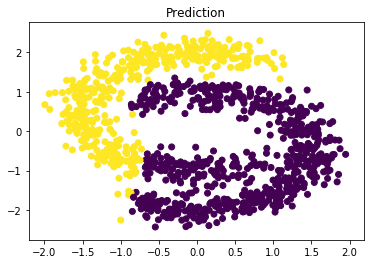

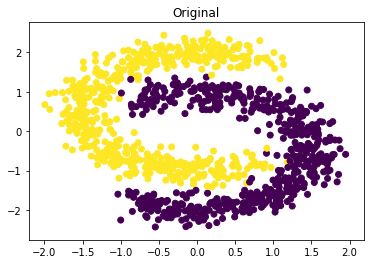

In [613]:
# definir les hyper-parametres
reseauSizes=[2, 3, 2]
mu = 0.39
epoque=30
K_minibatch=10
lambda1=0.00001
lambda2=0.00002
# Faire l'entrainement
t1 = time.clock()
rn = ReseauLoop(reseauSizes,rect,softmax) 
rn.gradiantDescentMiniBatch(moons_train_data, epoque, K_minibatch, mu, lambda1, lambda2, moons_valid_data)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour entrainer le reseau',rn.sizes,' sur ', moons_train_data.shape[0],' points de training data et ',moons_valid_data.shape[0],' points de validation data.'

# Faire les tests
t1 = time.clock()
classes_pred=rn.compute_predictions(moons_test_inputs)
classes_pred=np.argmax(rn.compute_predictions(moons_test_inputs),axis=1)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour calculer les predictions sur ', moons_test_inputs.shape[0],' points de test'
err = 1.0 - np.mean(moons_test_labels==classes_pred)
print "L'erreur de test est de ", 100.0 * err,"%"

if len(moons_train_cols) == 2:
    # Surface de decision
    # Predire
    train_classes_pred=rn.compute_predictions(moons_train_data[:,:-1])
    train_classes_pred=np.argmax(train_classes_pred,axis=1)
    valid_classes_pred=rn.compute_predictions(moons_valid_data[:,:-1])
    valid_classes_pred=np.argmax(valid_classes_pred,axis=1)
    
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=train_classes_pred)
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=valid_classes_pred)
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=classes_pred)
    plt.title('Prediction')
    plt.show()

    # data original
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=moons_train_data[:,-1])
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=moons_valid_data[:,-1])
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=moons_test_labels)
    plt.title('Original')
    plt.show()
    
else:
    print 'Trop de dimensions (', len(moons_train_cols),') pour pouvoir afficher la surface de decision'


#### Exemple 5:

reseauSizes=[2, 10, 2] #change

mu = 0.50

epoque=40

K_minibatch=20 

lambda1=0.001 

lambda2=0.002 

Epoque 0 fini: 36 erreurs sur 200 validation data, Taux d'erreur: 0.18, Loss: 0.419768608335
Epoque 1 fini: 32 erreurs sur 200 validation data, Taux d'erreur: 0.16, Loss: 0.366553349039
Epoque 2 fini: 27 erreurs sur 200 validation data, Taux d'erreur: 0.135, Loss: 0.288351554672
Epoque 3 fini: 17 erreurs sur 200 validation data, Taux d'erreur: 0.085, Loss: 0.215893591222
Epoque 4 fini: 10 erreurs sur 200 validation data, Taux d'erreur: 0.05, Loss: 0.160242317586
Epoque 5 fini: 8 erreurs sur 200 validation data, Taux d'erreur: 0.04, Loss: 0.12960198957
Epoque 6 fini: 8 erreurs sur 200 validation data, Taux d'erreur: 0.04, Loss: 0.113735054766
Epoque 7 fini: 6 erreurs sur 200 validation data, Taux d'erreur: 0.03, Loss: 0.103802468825
Epoque 8 fini: 6 erreurs sur 200 validation data, Taux d'erreur: 0.03, Loss: 0.0980334650837
Epoque 9 fini: 6 erreurs sur 200 validation data, Taux d'erreur: 0.03, Loss: 0.0923413152525
Epoque 10 fini: 6 erreurs sur 200 validation data, Taux d'erreur: 0.03, 

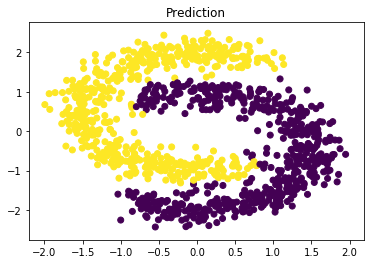

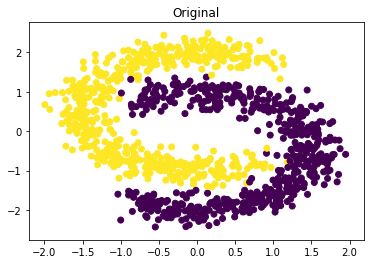

In [616]:
# definir les hyper-parametres
reseauSizes=[2, 10, 2] #change
mu = 0.50
epoque=40
K_minibatch=20 
lambda1=0.001 
lambda2=0.002 
# Faire l'entrainement
t1 = time.clock()
rn = ReseauLoop(reseauSizes,rect,softmax) 
rn.gradiantDescentMiniBatch(moons_train_data, epoque, K_minibatch, mu, lambda1, lambda2, moons_valid_data)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour entrainer le reseau',rn.sizes,' sur ', moons_train_data.shape[0],' points de training data et ',moons_valid_data.shape[0],' points de validation data.'

# Faire les tests
t1 = time.clock()
classes_pred=rn.compute_predictions(moons_test_inputs)
classes_pred=np.argmax(rn.compute_predictions(moons_test_inputs),axis=1)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour calculer les predictions sur ', moons_test_inputs.shape[0],' points de test'
err = 1.0 - np.mean(moons_test_labels==classes_pred)
print "L'erreur de test est de ", 100.0 * err,"%"

if len(moons_train_cols) == 2:
    # Surface de decision
    # Predire
    train_classes_pred=rn.compute_predictions(moons_train_data[:,:-1])
    train_classes_pred=np.argmax(train_classes_pred,axis=1)
    valid_classes_pred=rn.compute_predictions(moons_valid_data[:,:-1])
    valid_classes_pred=np.argmax(valid_classes_pred,axis=1)
    
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=train_classes_pred)
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=valid_classes_pred)
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=classes_pred)
    plt.title('Prediction')
    plt.show()

    # data original
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=moons_train_data[:,-1])
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=moons_valid_data[:,-1])
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=moons_test_labels)
    plt.title('Original')
    plt.show()
    
else:
    print 'Trop de dimensions (', len(moons_train_cols),') pour pouvoir afficher la surface de decision'


#### Exemple 6:

reseauSizes=[2, 10, 2] 

mu = 0.50

epoque=40

K_minibatch=20

lambda1=0.0001 #change

lambda2=0.0002 #change

Epoque 0 fini: 32 erreurs sur 200 validation data, Taux d'erreur: 0.16, Loss: 0.395096685432
Epoque 1 fini: 25 erreurs sur 200 validation data, Taux d'erreur: 0.125, Loss: 0.303813423359
Epoque 2 fini: 14 erreurs sur 200 validation data, Taux d'erreur: 0.07, Loss: 0.189648974125
Epoque 3 fini: 8 erreurs sur 200 validation data, Taux d'erreur: 0.04, Loss: 0.122931992885
Epoque 4 fini: 8 erreurs sur 200 validation data, Taux d'erreur: 0.04, Loss: 0.0897289242601
Epoque 5 fini: 6 erreurs sur 200 validation data, Taux d'erreur: 0.03, Loss: 0.0716049741031
Epoque 6 fini: 4 erreurs sur 200 validation data, Taux d'erreur: 0.02, Loss: 0.0617874533665
Epoque 7 fini: 2 erreurs sur 200 validation data, Taux d'erreur: 0.01, Loss: 0.0544359635937
Epoque 8 fini: 2 erreurs sur 200 validation data, Taux d'erreur: 0.01, Loss: 0.0495452372537
Epoque 9 fini: 2 erreurs sur 200 validation data, Taux d'erreur: 0.01, Loss: 0.0456331379895
Epoque 10 fini: 2 erreurs sur 200 validation data, Taux d'erreur: 0.01

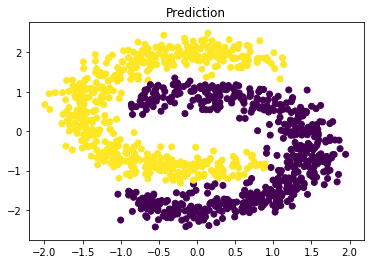

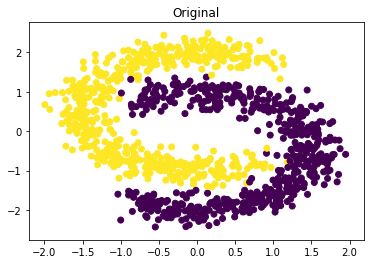

In [619]:
# definir les hyper-parametres
reseauSizes=[2, 10, 2] 
mu = 0.50
epoque=40
K_minibatch=20
lambda1=0.0001 #change
lambda2=0.0002 #change
# Faire l'entrainement
t1 = time.clock()
rn = ReseauLoop(reseauSizes,rect,softmax) 
rn.gradiantDescentMiniBatch(moons_train_data, epoque, K_minibatch, mu, lambda1, lambda2, moons_valid_data)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour entrainer le reseau',rn.sizes,' sur ', moons_train_data.shape[0],' points de training data et ',moons_valid_data.shape[0],' points de validation data.'

# Faire les tests
t1 = time.clock()
classes_pred=rn.compute_predictions(moons_test_inputs)
classes_pred=np.argmax(rn.compute_predictions(moons_test_inputs),axis=1)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour calculer les predictions sur ', moons_test_inputs.shape[0],' points de test'
err = 1.0 - np.mean(moons_test_labels==classes_pred)
print "L'erreur de test est de ", 100.0 * err,"%"

if len(moons_train_cols) == 2:
    # Surface de decision
    # Predire
    train_classes_pred=rn.compute_predictions(moons_train_data[:,:-1])
    train_classes_pred=np.argmax(train_classes_pred,axis=1)
    valid_classes_pred=rn.compute_predictions(moons_valid_data[:,:-1])
    valid_classes_pred=np.argmax(valid_classes_pred,axis=1)
    
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=train_classes_pred)
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=valid_classes_pred)
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=classes_pred)
    plt.title('Prediction')
    plt.show()

    # data original
    plt.scatter(moons_train_data[:,0],moons_train_data[:,1],c=moons_train_data[:,-1])
    plt.scatter(moons_valid_data[:,0],moons_valid_data[:,1],c=moons_valid_data[:,-1])
    plt.scatter(moons_test_data[:,0],moons_test_data[:,1],c=moons_test_labels)
    plt.title('Original')
    plt.show()
    
else:
    print 'Trop de dimensions (', len(moons_train_cols),') pour pouvoir afficher la surface de decision'


### Conclusion: 
* Quand reseauSizes=[2, 2, 2], le nombre de neurones de la couche cachée est égal à 2. C'est le même que le nombre de neurones sur la couche d'entrée et sur la couche de sortie. On a constaté que la frontière de décision est une frontière linéaire. Ce sont les autres hyper-paramètres qui déplacent la position de la frontière linéaire.
* Quand reseauSizes=[2, 3, 2], le nombre de neurones de la couche cachée est égal à 3. On a constaté que la frontière de décision est non-linéaire. Quand on ajuste les autres hyper-paramètres, on peut obtenir parfois une frontière de décision qui sépare bien les données, le taux d'erreur est d'environ 3-5.0% (ou parfois 12-16%). Mais le taux d'erreur n'est pas très stable pour chaque entrainement.
* Quand reseauSizes=[2, 10, 2], le nombre de neurones de la couche cachée est égal à 10. On a constaté que la frontière de décision sépare parfaitement les données, le taux d'erreur est d'environ 1.0% et il est très stable.
* On constate aussi que le paramètre lambda (régularisation) va influencer le taux d'erreur. Quand lambda diminue, la descente du gradient va plus bas, car ici il n'y a pas beaucoup de bruit dans l'emsemble de d'entrainement, donc le taux d'erreur de test diminue aussi.

## Question 6:
> 6.Dans un deuxième temps, faites une copie de votre implémentation en vue d’en faire une version modiﬁée efficace qui manipulera les lots de K exemples avec des calculs matriciels (plutôt qu’une boucle). Reprenez les expressions matricielles numpy établies dans la première partie, et adaptez-les au cas des mini-lots de taille K. Indiquez dans votre rapport comment vous les avez adaptées (précisez les anciennes et nouvelles expressions avec les dimensions de chaque matrice).

#### Réponse:
Quelques exemples de La method boucle:

```

# forward propagation, un exemple par fois
# x est col, n'inclut pas de y
def fprop(self, x):
    # obtenir un vecteur, dimension=nombre de neurones de couche cachee.
    Ha=np.dot(self.w1, x) + self.b1
    # obtenir un vecteur apres la function d'activation, dimension=nombre de neurones de couche cachee
    Hs=self.activationf(Ha)
    # obtenir un vecteur, dimension=nombre de neurones de sorties
    Oa=np.dot(self.w2, Hs) + self.b2
    # vecteur de sortie, apres softmax, dimension=nombre de neurones de sorties
    Os=self.outputf(Oa)
    return (Ha,Hs,Oa,Os)    
    
def bprop_minibatch(self, mini_data, mu, lambda1, lambda2): 
    k=len(mini_data)
    # faire le boucle
    for x in mini_data:
        x=x[:-1][:,None]
        # obtenir toutes les values avant les neurones et toutes les valeurs 
        # apres les neurones pour une echantillon
        Ha,Hs,Oa,Os=self.fprop(x)
        # faire la retro-propagation a partir de la 2eme couche a l'inverse.
        # Gradient de la couche de sortie.
        Grad_Oa = Os - y
        # lambda pour le risque empirique regularise lambda2*||w||^2_2 pour chaque couche
        R2 =lambda1*np.sign(self.w2) + 2*lambda2*self.w2
        # sum de grad_W2, pour k mini batch.
        # Dimension de Os(vecteur de couche sortie) * dimension Hs(vecteur horizontal)
        Grad_W2+=np.dot(Grad_Oa, Hs.T) +R2
        # sum de Grad_B2, pour k mini batch, grad_b = grad_Oa, dimension= dimension de Oa
        Grad_B2+=Grad_Oa
        # Grad_Hs= transforme de la martice de w2 dot vecteur de grad_Oa
        # dimension= nombre de neurone de couche cachee
        Grad_Hs= np.dot(self.w2.T, Grad_Oa)
        # obtenir la valeur de la derivation de la fonction d'activation
        derivation=eval(self.activationf.__name__+'_prime')(Ha)
        # derivation=eval(self.activationf.__name__+'_derivate')(HSs_layers[l])
        Grad_Ha=Grad_Hs * derivation
        # lambda pour le risque empirique regularise lambda2*||w||^2_2 pour chaque couche
        R1 =lambda1*np.sign(self.w1) + 2*lambda2*self.w1
        # sum de grad_W1, pour k mini batch.
        # Dimension de Ha(vecteur de couche cachee) * dimension de x(vecteur horizontal)
        Grad_W1+=np.dot(Grad_Ha, x.T) + R1
        # sum de Grad_B1, pour k mini batch. grad_B1 = grad_Ha, dimension= dimension de Ha
        Grad_B1+=Grad_Ha
    # faire le descent gradient
    self.w1 -=  Grad_W1 * mu / k
    self.b1 -= Grad_B1 * mu / k
    self.w2 -=  Grad_W2 * mu / k
    self.b2 -= Grad_B2 * mu / k
    
```


### Nous implémentons une classe ReseauMLP plus genérale pour les autres questions
Nous programmons une classe ReseauMLP(Multi-Layer Perceptron) plus générale nous-même. Avec cette classe, on implémente un réseau de neurones avec n'importe quel nombre de couches cachées de neurones et n'importe quel nombre de neurones pour chaque couche cachée. Toutes les fonctions de classe ReseauMLP calculent en matrice de numpy, c'est plus efficace.
```
rmlp = ReseauMLP(sizes=[784, 30, 10], activationFunction=rect, outputFunction=softmax)
```
Cette classe contient les fonctions comme fprop, bprop, gradient_check, gradiantDescentMiniBatch, compute_predictions, etc.


Quelques exemples de la method matrice(Nous implémentons une classe ReseauMLP plus genérale pour les autres questions, voyez le code de ReseauMLP pour des details):
```

    def fprop(self, Xs):
        '''
        # Xs(col) n'inclut y
        '''
        # HSs= sorties de chaque neurone de chaque couche, chaque vecteur vient de chaque echantillon
        # HAs= w*hs^(l-1)+b , valeurs avant activationF, chaque vecteur vient de chaque echantillon
        HSs = Xs
        # obtenir toutes les valeurs avant les neurones et toutes les valeurs 
        # apres les neurones pour tous les echantillons
        HAs_layers = [ HSs ]
        HSs_layers = [ HSs ]
        l=1
        for w, b in zip(self.weights, self.biases):
            # Obtenir HAs de l eme couche
            HAs=np.dot(w, HSs) + b
            if l < self.num_layers-1 :
                HSs = self.activationf(HAs)
                l+=1
            else:
                # si c'est la dernier couche, utilise la function softmax.
                HSs = self.outputf(HAs)
            # HAs_layers et HSs_layers contiennent toutes les valeurs de neurones avant 
            # et apres la fonction d'activation. ca vient des echantillons de minibatch, 
            # chaque couche est une matrice dont chaque colonne correspond a un echantillon
            HAs_layers.append(HAs)
            HSs_layers.append(HSs)
        return (HAs_layers,HSs_layers)
    
    def bprop(self, mini_data, mu, lambda1, lambda2): 
        '''
        # mini_data(row) inclut y
        # mu：taux d'apprentissage
        # lambda1 pour le  risque empirique r´egularis´e lambda1*||w||_1 pour chaque couche
        # lambda2 pour le  risque empirique r´egularis´e lambda2*||w||^2_2 pour chaque couche
        '''
        k=len(mini_data) # important ici, evite les problemes
        # pretraiter y en utilisant onehot
        if self.num_sortie_neurone>1:
            Ys=onehots( mini_data[:,-1] , self.num_sortie_neurone ).T
        else:
            Ys=mini_data[:,-1]
        mini_data=mini_data[:,:-1].T
     
        # obtenir toutes les valeurs avant les neurones et toutes les valeurs apres les neurones pour tous les echantillons
        HAs_layers,HSs_layers=self.fprop(mini_data)   
        # obtenir les gradients pour les poids et biais
        Grad_Ws = [  ]
        Grad_Bs = [  ]
        # obtenir les gradients pour les neurones
        # la couche de sortie.
        Grad_HAs = [ HSs_layers[-1] - Ys ]
        Grad_HSs = [ np.zeros(self.num_sortie_neurone) ] #Grad_HS
        # faire la retro-propagation a partir de la 2eme couche a l'inverse
        # "l" est l'indice de couche
        for l in xrange( self.num_layers-2, -1, -1 ) : 
            # lambda1 pour le  risque empirique regularise lambda1*||w||_1 pour chaque couche
            # lambda2 pour le  risque empirique regularise lambda2*||w||^2_2 pour chaque couche
            regularizedGrad = lambda1*np.sign(self.weights[l]) + 2*lambda2*self.weights[l]
            # c'est deja le sum de minibatch(np.dot) de grad_W, apres on va diviser par len(minibatch)
            # dimension de grad_ws[l]=nombre de couche(l+1) * nombre de couche(l)
            # Grad_HAs[0] est la prochaine couche (l+1). 
            Grad_Ws.insert(0, np.dot(Grad_HAs[0], HSs_layers[l].T) + regularizedGrad*k ) 
            # grad_b = grad_ha de la prochaine couche, sum K echantillons de minibatch
            Grad_Bs.insert(0, np.sum(Grad_HAs[0], axis=1)[:,None] )
            # Il y a k colonne pour HSs[l], car ca vient par K echantillons de minibatch.
            # chaque vecteur vertical = dimension de HS,ca vient de une echantillons.
            Grad_HSs.insert(0, np.dot(self.weights[l].T, Grad_HAs[0]) )
            # obtenir la valeur de la derivation de la fonction d'activation
            derivation=eval(self.activationf.__name__+'_prime')(HAs_layers[l])
            # derivation=eval(self.activationf.__name__+'_derivate')(HSs_layers[l])
            Grad_HAs.insert(0, Grad_HSs[0] * derivation )
        # Descente du gradient pour chaque w,b cette fois de mini_batch
        self.weights = [w - gw * mu / k  for w, gw in zip(self.weights, Grad_Ws)]
        self.biases = [b - gb * mu / k  for b, gb in zip(self.biases, Grad_Bs)]
```

In [56]:
class ReseauMLP(object):
    
    def __init__(self, sizes, activationFunction, outputFunction):
        '''
        # le reseau neurone plus general, realise par matrice calcule
        # sizes = [2, 3, 2]=[couche entree, couche cache, couche sortie]
        # activationFunction: la fonction d'activation
        # outputFunction: la fonction sortie
        '''
        
        # combien de couches, avec couche entree et couche sortie.
        self.num_layers = len(sizes)
        self.num_sortie_neurone = sizes[-1]
        self.sizes = sizes
        self.activationf = activationFunction
        self.outputf = outputFunction
        
        # On utilise vecteur colonne pour exprimer les biais de chaque couche 
        self.biases = [np.zeros(l)[:,None] for l in sizes[1:]] 
        # sample the weights of a layer from a uniform distribution in -1/√nc , 1/√nc 
        # , where nc is the number of inputs for this layer
        self.weights = [np.random.uniform(-l**-0.5,l**-0.5,lplus*l).reshape(lplus,l)
                        for lplus, l in zip(sizes[1:], sizes[:-1])]


    def compute_predictions(self, Xs):
        '''
        # prediction de forward propagation pour matrice echantillon.
        # Xs(row) n'inclut y, chaque rangee est un echantillon de d dimension.
        # retourner les valeurs de chaque neurone de sortie, par rangee(row)
        '''
        
        # HSs= sorties de chaque neurone de chaque couche, 
        # chaque vecteur vient de chaque echantillon
        HSs=Xs.T
        l=1
        for w, b in zip(self.weights, self.biases):
            if l < self.num_layers-1 :
                HSs = self.activationf(np.dot(w, HSs) + b)
                l+=1
            else:
                HSs = self.outputf(np.dot(w, HSs) + b)
        return HSs.T

    def evaluateAccuracy(self, test_data):
        '''
        # afficher le nombre de prediction correct pour test_data 
        # quand on fait chaque descente de gradient.
        '''
        
        if self.num_sortie_neurone>1:
            classes_pred=np.argmax(self.compute_predictions(test_data[:,:-1]), axis=1)
        else:
            # seulement pour output function=sigmoid
            classes_pred=np.where(self.compute_predictions(test_data[:,:-1])>0.5,1.0,0.0)
            classes_pred=classes_pred.reshape(len(classes_pred))
        correct= test_data[:,-1]==classes_pred
        return classes_pred[correct].size

    def evaluate(self, test_data):
        '''
        # test_data: row, inclut y
        # return taux d'erreur,num d'erreur, loss pour test_data 
        # quand on fait chaque descente de gradient.
        # retourne taux d'erreur, numero de erreur, loss
        '''
        
        if self.num_sortie_neurone>1:
            classes_pred=np.argmax(self.compute_predictions(test_data[:,:-1]), axis=1)
        else:
            # seulement pour output function=sigmoid
            classes_pred=np.where(self.compute_predictions(test_data[:,:-1])>0.5,1.0,0.0)
            classes_pred=classes_pred.reshape(len(classes_pred))
        err= test_data[:,-1]!=classes_pred
        n_err=classes_pred[err].size
        taux=float(n_err)/float(len(test_data))
        return ( taux, n_err, self.loss(test_data) )
       
            
    def fprop(self, Xs):
        '''
        # forward_propagation pour ha et hs=activationF(ha) pour chaque layer
        # obtenir toutes les valeurs avant les neurones et toutes les values 
        # apres les neurones pour tous les echantillons
        # Xs(col) n'inclut y
        '''
        
        # HSs= sorties de chaque neurone de chaque couche, 
        # chaque vecteur vient de chaque echantillon
        # HAs= w*hs^(l-1)+b , valeurs avant activationF, 
        # chaque vecteur vient de chaque echantillon
        HSs = Xs
        # obtenir toutes les valeurs avant les neurones et toutes les valeurs 
        # apres les neurones pour tous les echantillons
        HAs_layers = [ HSs ]
        HSs_layers = [ HSs ]
        l=1
        for w, b in zip(self.weights, self.biases):
            # Obtenir HAs de l eme couche
            HAs=np.dot(w, HSs) + b
            if l < self.num_layers-1 :
                HSs = self.activationf(HAs)
                l+=1
            else:
                # si c'est la dernier couche, utilise la function softmax.
                HSs = self.outputf(HAs)
            # HAs_layers et HSs_layers contiennent toutes les valeurs de neurones avant 
            # et apres la fonction d'activation. ca vient des echantillons de minibatch, 
            # chaque couche est une matrice dont chaque colonne correspond a un echantillon
            HAs_layers.append(HAs)
            HSs_layers.append(HSs)
            
        return (HAs_layers,HSs_layers)
    
    
    def bprop(self, mini_data, mu, lambda1, lambda2): 
        '''
        # backward propagation
        # retro-propagation le reseau en utilisant mini_data(echantillons), 
        # et mise a jour des poids et des biais
        # mini_data(row) inclut y
        # mu：taux d'apprentissage
        # lambda1 pour le  risque empirique r´egularis´e lambda1*||w||_1 pour chaque couche
        # lambda2 pour le  risque empirique r´egularis´e lambda2*||w||^2_2 pour chaque couche
        '''
        
        k=len(mini_data) # important ici, evite les problemes
        
        # pretraiter y en utilisant onehot
        if self.num_sortie_neurone>1:
            Ys=onehots( mini_data[:,-1] , self.num_sortie_neurone ).T
        else:
            Ys=mini_data[:,-1]
        mini_data=mini_data[:,:-1].T
        
        # obtenir toutes les valeurs avant les neurones et toutes les valeurs 
        # apres les neurones pour tous les echantillons
        HAs_layers,HSs_layers=self.fprop(mini_data)
        
        # obtenir les gradients pour les poids et biais
        Grad_Ws = [  ]
        Grad_Bs = [  ]
        # obtenir les gradients pour les neurones
        # la couche de sortie.
        Grad_HAs = [ HSs_layers[-1] - Ys ]
        Grad_HSs = [ np.zeros(self.num_sortie_neurone) ] #Grad_HS
        # faire la retro-propagation a partir de la 2eme couche a l'inverse
        # "l" est l'indice de couche
        for l in xrange( self.num_layers-2, -1, -1 ) : 
            # lambda1 pour le  risque empirique regularise lambda1*||w||_1 pour chaque couche
            # lambda2 pour le  risque empirique regularise lambda2*||w||^2_2 pour chaque couche
            regularizedGrad = lambda1*np.sign(self.weights[l]) + 2*lambda2*self.weights[l]
            # c'est deja le sum de minibatch(np.dot) de grad_W, 
            # apres on va diviser par len(minibatch)
            # dimension de grad_ws[l]=nombre de couche(l+1) * nombre de couche(l)
            # Grad_HAs[0] est la prochaine couche (l+1). 
            Grad_Ws.insert(0, np.dot(Grad_HAs[0], HSs_layers[l].T) + regularizedGrad*k ) 
            # grad_b = grad_ha de la prochaine couche, sum K echantillons de minibatch
            Grad_Bs.insert(0, np.sum(Grad_HAs[0], axis=1)[:,None] )
            # Il y a k colonne pour HSs[l], car ca vient par K echantillons de minibatch.
            # chaque vecteur vertical = dimension de HS,ca vient de une echantillons.
            Grad_HSs.insert(0, np.dot(self.weights[l].T, Grad_HAs[0]) )
            # obtenir la valeur de la derivation de la fonction d'activation
            derivation=eval(self.activationf.__name__+'_prime')(HAs_layers[l])
            # derivation=eval(self.activationf.__name__+'_derivate')(HSs_layers[l])
            Grad_HAs.insert(0, Grad_HSs[0] * derivation )

        # Descente du gradient pour chaque w,b cette fois de mini_batch
        self.weights = [w - gw * mu / k  for w, gw in zip(self.weights, Grad_Ws)]
        self.biases = [b - gb * mu / k  for b, gb in zip(self.biases, Grad_Bs)]

        
    def loss(self, Xs):
        '''
        # calculer la valeur de la perte avec des thetas(w,s) courants du reseau
        # en utilisant la function J(theta)=-log(Os_Yeme(x))
        # Xs(row) inclut y
        '''
        
        k = len(Xs)
        Ys=np.array(Xs[:,-1], dtype=int)
        Xs=Xs[:,:-1].T
        #obtenir les valeurs de neurones de la sortie en donnant les x de l'échantillon
        HAs_layers,HSs_layers=self.fprop(Xs)
        Os=HSs_layers[-1]
        # calculer la perte en utilisant la function J(theta)=-log(Os_Yeme(x))
        if self.num_sortie_neurone>1:
            perte = np.array([-np.log(o[y]) for o,y in zip(Os.T,Ys)]).sum() / k
        else:
            Os=Os.reshape(-1)
            # quand la sortie est seulement un neurone
            perte = ( -np.dot(Ys, np.log(Os).T) - np.dot((1 - Ys), np.log(1 - Os).T) ) / k

        return perte

    def gradient_checking(self, Xs, id_w, id_b, epsilon, lambda1, lambda2):
        '''
        # Verification du gradient par difference finie.
        # Xs: row, les echantillons
        # id_w, id_b: indiquer quel poids[couche,row(num de neurones de couche+1),col] 
        # et quel biais[couche,num de neurones de couche+1]
        # epsilon: entre 10e-6,10e-4
        # lambda1 pour le  risque empirique regularise lambda1*||w||_1 pour chaque couche
        # lambda2 pour le  risque empirique regularise lambda2*||w||^2_2 pour chaque couche
        '''
        
        Ws_original=np.copy(self.weights)
        Bs_original=np.copy(self.biases)
        
        # gradient_checking pour theta de poids
        # sauvegarder le w et b precis.
        w_original=self.weights[id_w[0]][id_w[1],id_w[2]]
        self.weights[id_w[0]][id_w[1],id_w[2]]+=epsilon
        loss_plus=self.loss(Xs)
        print 'loss_plus',loss_plus
        self.weights[id_w[0]][id_w[1],id_w[2]]-=2*epsilon
        loss_moins=self.loss(Xs)
        print 'loss_moins',loss_moins
        diff_finie_w= (loss_plus - loss_moins) / (epsilon * 2)
        # recuperer le parametre a sa valeur de depart
        self.weights[id_w[0]][id_w[1],id_w[2]] = w_original
        
        #valeur de ce poids quand on utilise la methode de la descente du gradient
        self.bprop(Xs,mu=1, lambda1=lambda1, lambda2=lambda2)
        grad_w= w_original - self.weights[id_w[0]][id_w[1],id_w[2]]
        # le ratio doit etre entre 0.99 et 1.01.
        print  'K=',len(Xs),' diff_finie=',diff_finie_w, ',grad w',id_w,'=',grad_w,' ,Ration diff_finie/grad:',diff_finie_w/grad_w
        self.weights=np.copy(Ws_original)
        self.biases=np.copy(Bs_original)
        
        # gadient_checking pour theta de biais
        # sauvegarder le w et b precis.
        b_original=self.biases[id_b[0]][id_b[1]][0]
        self.biases[id_b[0]][id_b[1]][0]+=epsilon
        loss_plus=self.loss(Xs)
        self.biases[id_b[0]][id_b[1]][0]-=2*epsilon
        loss_moins=self.loss(Xs)
        diff_finie_b= (loss_plus - loss_moins) / (epsilon * 2)
        # recuperer le parametre a sa valeur de depart
        self.biases[id_b[0]][id_b[1]][0]=b_original
        
        #valeur de ce poids quand on utilise la methode de la descente du gradient
        self.bprop(Xs,mu=1, lambda1=lambda1, lambda2=lambda2)
        grad_b= b_original - self.biases[id_b[0]][id_b[1]][0]
        # le ratio doit etre entre 0.99 et 1.01.
        print  'K=',len(Xs),' diff_finie=',diff_finie_b,',grad b',id_b,'=',grad_b,',Ration diff_finie/grad:',diff_finie_b/grad_b
        self.weights=np.copy(Ws_original)
        self.biases=np.copy(Bs_original)
            
        
    def gradiantDescentMiniBatch(self, training_data, epoque, K_batch_size, mu,
            lambda1, lambda2, validation_data=None, test_data=None, display=False):
        '''
        # la methode de descente du gradient pour minibatch
        # training_data(row*n): l'ensemble des donnees d'entrainement
        # epoque: la fois d'entrainement
        # K_batch_szie: la taille de data pour chaque fois d'entrainement
        # mu: taux d'apprentissage
        # lambda: hyper-parm`etres pour le risque empirique regularise
        # lambda1 pour le  risque empirique regularise lambda1*||w||_1 pour chaque couche
        # lambda2 pour le  risque empirique regularise lambda2*||w||^2_2 pour chaque couche
        # validation_data(row*n): l'ensemble de donnees de validation
        # test_data(row*n): l'ensemble de donnees de test
        '''
        
        n = len(training_data)
        logs={}
        ELoss=[]
        EErr=[]
        ETaux=[]
        VLoss=[]
        VErr=[]
        VTaux=[]
        TLoss=[]
        TErr=[]
        TTaux=[]
        for ep in xrange(epoque):
            # diviser training data selon la taille de mini_batch
            mini_batches = [
                training_data[ k: k+K_batch_size ]
                for k in xrange(0, n, K_batch_size)]
            for i, mini_data in enumerate(mini_batches):
                # mise à jour  w et b une fois selon un petit ensemble d'entrainement de donnees
                self.bprop(mini_data, mu, lambda1, lambda2)
                # donne validation, donc calcule aussi taux etc sur training_data chaque batch
                if validation_data is not None: 
                    taux,err,loss=self.evaluate(training_data)
                    ELoss.append(loss)
                    EErr.append(err)
                    ETaux.append(taux)
                    if display:
                        print "Epoque {0}, batch {5}: {1} erreurs sur {2} training data, Taux d'erreur: {3}, Loss: {4}".format(
                            ep, err , len(training_data), taux, loss, i )

            # faire la validation
            if validation_data is not None:
                taux,err,loss=self.evaluate(validation_data)
                VLoss.append(loss)
                VErr.append(err)
                VTaux.append(taux)
                if display:
                    print "Epoque {0} fini: {1} erreurs sur {2} validation data, Taux d'erreur: {3}, Loss: {4}".format(
                        ep, err , len(validation_data), taux, loss )
                    
            # faire le test
            if test_data is not None:
                taux,err,loss=self.evaluate(test_data)
                TLoss.append(loss)
                TErr.append(err)
                TTaux.append(taux)
                if display:
                    print "Epoque {0} fini: {1} erreurs sur {2} test data, Taux d'erreur: {3}, Loss: {4}".format(
                        ep, err , len(test_data), taux, loss )
            logs['ELoss']=ELoss
            logs['EErr']=EErr
            logs['ETaux']=ETaux
            logs['VLoss']=VLoss
            logs['VErr']=VErr
            logs['VTaux']=VTaux
            logs['TLoss']=TLoss
            logs['TErr']=TErr
            logs['TTaux']=TTaux
        return logs
    
    
    def gradiantDescentMiniBatchVite(self, training_data, epoque, K_batch_size, mu,
            lambda1, lambda2, validation_data=None, test_data=None, display=False):
        '''
        # la methode de descente du gradient pour minibatch
        # training_data(row*n): l'ensemble de donnees d'entrainement
        # epoque: la fois d'entrainement
        # K_batch_szie: la taille de data pour chaque fois d'entrainement
        # mu: taux d'apprentissage
        # lambda: hyper-parmetres pour le risque empirique regularis´e
        # lambda1 pour le  risque empirique regularise lambda1*||w||_1 pour chaque couche
        # lambda2 pour le  risque empirique regularise lambda2*||w||^2_2 pour chaque couche
        # validation_data(row*n): l'ensemble de donnees de validation
        # test_data(row*n): l'ensemble de donnees de test
        '''
        
        n = len(training_data)
        logs={}
        ELoss=[]
        ETaux=[]
        VLoss=[]
        VTaux=[]
        TLoss=[]
        TTaux=[]
        for ep in xrange(epoque):
            # diviser training data selon la taille de mini_batch
            mini_batches = [
                training_data[ k: k+K_batch_size ]
                for k in xrange(0, n, K_batch_size)]
            for i, mini_data in enumerate(mini_batches):
                # mise à jour  w et b un fois selon un petit ensemble d'entrainement de donnees
                self.bprop(mini_data, mu, lambda1, lambda2)
                
            # faire la validation
            if validation_data is not None:
                # pour plus rapide , calcule taux etc sur train data et validation data apres chaque epoque
                taux,err,loss=self.evaluate(training_data)
                ELoss.append(loss)
                ETaux.append(taux)
                if display:
                    print "Epoque {0} fini: {1} erreurs sur {2} train data, Taux d'erreur: {3}, Loss: {4}".format(
                        ep, err , len(training_data), taux, loss )
                taux,err,loss=self.evaluate(validation_data)
                VLoss.append(loss)
                VTaux.append(taux)
                if display:
                    print "Epoque {0} fini: {1} erreurs sur {2} validation data, Taux d'erreur: {3}, Loss: {4}".format(
                        ep, err , len(validation_data), taux, loss )
                    
            # faire le test
            if test_data is not None:
                taux,err,loss=self.evaluate(test_data)
                TLoss.append(loss)
                TTaux.append(taux)
                if display:
                    print "Epoque {0} fini: {1} erreurs sur {2} test data, Taux d'erreur: {3}, Loss: {4}".format(
                        ep, err , len(test_data), taux, loss )
                if taux < float(0.019) :
                    break
                    
            logs['ELoss']=ELoss
            logs['ETaux']=ETaux
            logs['VLoss']=VLoss
            logs['VTaux']=VTaux
            logs['TLoss']=TLoss
            logs['TTaux']=TTaux
        return logs

# test
#rmlp=ReseauMLP([2,3,4,3],rect,softmax)
#test=np.array([[-1,2],[2,3]])
#print 'x=',test
#print 'matrice:',rmlp.compute_predictions(test)

## Question 7:
> 7.Comparez vos deux implémentations (avec et sans boucle sur les exemples du lot) pour vériﬁer qu’elles donnent le même gradient total sur les paramètres, d’abord avec K = 1. Puis comparez-les avec K = 10. Joignez à votre rapport les affichages numériques eﬀectués pour cette comparaison.

#### Réponse:
#### K=1:

In [53]:
# defini les hyper-parametres
reseauSizes=[2, 2, 2]
rmlp = ReseauMLP(reseauSizes,rect,softmax) 
rn = ReseauLoop(reseauSizes,rect,softmax) 
# pour le meme poids et biais initial
rn.w1=np.copy(rmlp.weights[0])
rn.b1=np.copy(rmlp.biases[0])
rn.w2=np.copy(rmlp.weights[1])
rn.b2=np.copy(rmlp.biases[1])

mu = 1
epoque=10 
lambda1=0.0001
lambda2=0.0002

epsilon=0.0001
K_minibatch=1
data=moons_test_data[0:K_minibatch]
print 'data,',data
id_w1=[0,0]
id_b1=0
id_w2=[1,1]
id_b2=1
print 'Reseau Loop:'
rn.gradient_checking_minibatch(data, id_w1, id_b1, id_w2, id_b2, epsilon,lambda1,lambda2)

id_w=[0,0,0]
id_b=[0,0]
print '\nReseau Matrice:'
rmlp.gradient_checking(data, id_w, id_b, epsilon,lambda1,lambda2)
id_w=[1,1,1]
id_b=[1,1]
rmlp.gradient_checking(data, id_w, id_b, epsilon,lambda1,lambda2)

data, [[-0.515599  0.865439  0.      ]]
Reseau Loop:
loss_plus 0.683253349138
loss_moins 0.683220229743
K= 1  diff_finie: 0.165596975031 , grad w1 [0, 0] : 0.165936562564 Ration diff_finie/grad: 0.997953509899
K= 1  diff_finie: -0.321173964711 , grad b1 0 : -0.32117396471 Ration diff_finie/grad: 1.0
K= 1  diff_finie: 0.0 , grad w2 [1, 1] : 0.00030326447651 Ration diff_finie/grad: 0.0
K= 1  diff_finie: 0.495020169097 , grad b2 1 : 0.495020169092 Ration diff_finie/grad: 1.00000000001

Reseau Matrice:
loss_plus 0.683253349138
loss_moins 0.683220229743
K= 1  diff_finie= 0.165596975031 ,grad w [0, 0, 0] = 0.165936562564  ,Ration diff_finie/grad: 0.997953509899
K= 1  diff_finie= -0.321173964711 ,grad b [0, 0] = -0.32117396471 ,Ration diff_finie/grad: 1.0
loss_plus 0.683236789301
loss_moins 0.683236789301
K= 1  diff_finie= 0.0 ,grad w [1, 1, 1] = 0.00030326447651  ,Ration diff_finie/grad: 0.0
K= 1  diff_finie= 0.495020169097 ,grad b [1, 1] = 0.495020169092 ,Ration diff_finie/grad: 1.000000000

#### K=10:

In [626]:

K_minibatch=10
data=moons_test_data[0:K_minibatch]
id_w1=[0,0]
id_b1=0
id_w2=[1,1]
id_b2=1
print 'Reseau Loop:'
rn.gradient_checking_minibatch(data, id_w1, id_b1, id_w2, id_b2, epsilon,lambda1,lambda2)

id_w=[0,0,0]
id_b=[0,0]
print '\nReseau Matrice:'
rmlp.gradient_checking(data, id_w, id_b, epsilon,lambda1,lambda2)
id_w=[1,1,1]
id_b=[1,1]
rmlp.gradient_checking(data, id_w, id_b, epsilon,lambda1,lambda2)

Reseau Loop:
loss_plus 0.671362094243
loss_moins 0.671342099098
K= 10  diff_finie: 0.0999757222625 , grad w1 [0, 0] : 0.099744277726 Ration diff_finie/grad: 1.00232037909
K= 10  diff_finie: -0.0152350174948 , grad b1 0 : -0.0152350174862 Ration diff_finie/grad: 1.00000000056
K= 10  diff_finie: 0.0892160738908 , grad w2 [1, 1] : 0.0895053638729 Ration diff_finie/grad: 0.996767903402
K= 10  diff_finie: 0.131985385517 , grad b2 1 : 0.131985385543 Ration diff_finie/grad: 0.999999999799

Reseau Matrice:
loss_plus 0.671362094243
loss_moins 0.671342099098
K= 10  diff_finie= 0.0999757222625 ,grad w [0, 0, 0] = 0.099744277726  ,Ration diff_finie/grad: 1.00232037909
K= 10  diff_finie= -0.0152350174948 ,grad b [0, 0] = -0.0152350174862 ,Ration diff_finie/grad: 1.00000000056
loss_plus 0.671361018096
loss_moins 0.671343174881
K= 10  diff_finie= 0.0892160738908 ,grad w [1, 1, 1] = 0.0895053638729  ,Ration diff_finie/grad: 0.996767903402
K= 10  diff_finie= 0.131985385517 ,grad b [1, 1] = 0.1319853855

## Question 8:
> 8.Mesurez le temps que prend une époque sur MNIST (1 époque = 1 passage complet à travers l’ensemble d’entrainement) pour K = 100 avec chacune des deux implémentations (mini-lot par boucle, et mini-lot avec calcul matriciel).

#### Réponse:

In [54]:
# 784 neurones d'entree, 1 couche cachee de 30 neurones, 10 neurones de sortie
reseauSizes=[784, 30, 10]
mu = 0.35
epoque=1
K_minibatch=100
lambda1=0.0001
lambda2=0.0002

print '\nReseauMLP Entrainement commence....'
# Faire l'entrainement
t1 = time.clock()
rmlp = ReseauMLP(reseauSizes,rect,softmax) 
rmlp.gradiantDescentMiniBatch(mnist_train_data, epoque, K_minibatch, mu, lambda1, lambda2)
t2 = time.clock()
err,_,_=rmlp.evaluate(mnist_valid_data)
print 'Taux d\'erreur sur l\'ensemble de validation:',err
print 'Ca nous a pris ', t2-t1, ' secondes pour entrainer le reseau',rmlp.sizes,' sur ', mnist_train_data.shape[0],' points de training data .'

print '\nReseauLoop Entrainement commence....'
# Faire l'entrainement
t1 = time.clock()
rn = ReseauLoop(reseauSizes,rect,softmax) 
rn.gradiantDescentMiniBatch(mnist_train_data, epoque, K_minibatch, mu, lambda1, lambda2)
t2 = time.clock()
err,_,_=rn.evaluate(mnist_valid_data)
print 'Taux d\'erreur sur l\'ensemble de validation:',err
print 'Ca nous a pris ', t2-t1, ' secondes pour entrainer le reseau',rn.sizes,' sur ', mnist_train_data.shape[0],' points de training data .'



ReseauMLP Entrainement commence....
Taux d'erreur sur l'ensemble de validation: 0.0636
Ca nous a pris  1.169459  secondes pour entrainer le reseau [784, 30, 10]  sur  50000  points de training data .

ReseauLoop Entrainement commence....
Taux d'erreur sur l'ensemble de validation: 0.0692
Ca nous a pris  14.687171  secondes pour entrainer le reseau [784, 30, 10]  sur  50000  points de training data .


## Question 9:
> 9.Adaptez votre code pour qu’il calcule au vol, pendant l’entrainement, l’erreur de classiﬁcation totale sur l’ensemble d’entrainement, en plus du coût optimisé total (somme des L encourus), ceci pour chaque époque d’entrainement, et qu’après chaque époque d’entrainement, il calcule aussi l'erreur et le coût moyen sur l’ensemble de validation et de test. Faites en sorte qu’il les aﬃche après chaque époque les 6 nombres correspondants (erreur et coût moyen sur train, valid, test) et les écrive dans un ﬁchier.

#### Réponse:

In [470]:
# 784 neurones d'entree, 1 couche cachee de 30 neurones, 10 neurones de sortie
reseauSizes=[784, 30, 10]
mu = 0.1
epoque=2
K_minibatch=2000
lambda1=0.000001
lambda2=0.000002
print '\nReseauMLP Entrainement commence....'
# Faire l'entrainement
t1 = time.clock()
rmlp = ReseauMLP(reseauSizes,rect,softmax) 
rmlp.gradiantDescentMiniBatch(mnist_train_data, epoque, 
                            K_minibatch, mu, lambda1, lambda2, 
                            mnist_valid_data, mnist_test_data,
                            display=True)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes.'


ReseauMLP Entrainement commence....
Epoque 0, batch 0: 40690 erreurs sur 50000 training data, Taux d'erreur: 0.8138, Loss: 2.29269112805
Epoque 0, batch 1: 38321 erreurs sur 50000 training data, Taux d'erreur: 0.76642, Loss: 2.28088196375
Epoque 0, batch 2: 36641 erreurs sur 50000 training data, Taux d'erreur: 0.73282, Loss: 2.26852855732
Epoque 0, batch 3: 35226 erreurs sur 50000 training data, Taux d'erreur: 0.70452, Loss: 2.25618361055
Epoque 0, batch 4: 34115 erreurs sur 50000 training data, Taux d'erreur: 0.6823, Loss: 2.24315216041
Epoque 0, batch 5: 33336 erreurs sur 50000 training data, Taux d'erreur: 0.66672, Loss: 2.22902076078
Epoque 0, batch 6: 32504 erreurs sur 50000 training data, Taux d'erreur: 0.65008, Loss: 2.21486754729
Epoque 0, batch 7: 31274 erreurs sur 50000 training data, Taux d'erreur: 0.62548, Loss: 2.19961660164
Epoque 0, batch 8: 30130 erreurs sur 50000 training data, Taux d'erreur: 0.6026, Loss: 2.18361001307
Epoque 0, batch 9: 28199 erreurs sur 50000 train

#### Résultat 1, en utilisant les hyper-paramètres :
reseauSizes=[784, 30, 10]

mu = 0.1

epoque=2

K_minibatch=2000

lambda1=0.000001

lambda2=0.000002

le taux d'erreur de test=21.5%
* Epoque 1 fini: 2055 erreurs sur 10000 validation data, Taux d'erreur: 0.2055, Loss: 1.07675905773

* Epoque 1 fini: 2147 erreurs sur 10000 test data, Taux d'erreur: 0.2147, Loss: 1.08345231354

* Ca nous a pris  97.220662  secondes.

In [538]:
# 784 neurones d'entree, 1 couche cachee de 30 neurones, 10 neurones de sortie
reseauSizes=[784, 30, 10]
mu = 0.4
epoque=20
K_minibatch=800
lambda1=0.0
lambda2=0.0
print '\nReseauMLP Entrainement commence....'
# Faire l' entrainement
t1 = time.clock()
rmlp = ReseauMLP(reseauSizes,rect,softmax) 
logs=rmlp.gradiantDescentMiniBatch(mnist_train_data, epoque, 
                            K_minibatch, mu, lambda1, lambda2, 
                            mnist_valid_data, mnist_test_data,
                            display=True)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes.'


ReseauMLP Entrainement commence....
Epoque 0, batch 0: 36736 erreurs sur 50000 training data, Taux d'erreur: 0.73472, Loss: 2.24238932612
Epoque 0, batch 1: 30329 erreurs sur 50000 training data, Taux d'erreur: 0.60658, Loss: 2.17454623451
Epoque 0, batch 2: 29269 erreurs sur 50000 training data, Taux d'erreur: 0.58538, Loss: 2.08414661036
Epoque 0, batch 3: 22850 erreurs sur 50000 training data, Taux d'erreur: 0.457, Loss: 1.98604760616
Epoque 0, batch 4: 21415 erreurs sur 50000 training data, Taux d'erreur: 0.4283, Loss: 1.8868021178
Epoque 0, batch 5: 19312 erreurs sur 50000 training data, Taux d'erreur: 0.38624, Loss: 1.77240876197
Epoque 0, batch 6: 18531 erreurs sur 50000 training data, Taux d'erreur: 0.37062, Loss: 1.66099953672
Epoque 0, batch 7: 16445 erreurs sur 50000 training data, Taux d'erreur: 0.3289, Loss: 1.554895148
Epoque 0, batch 8: 16275 erreurs sur 50000 training data, Taux d'erreur: 0.3255, Loss: 1.43353962021
Epoque 0, batch 9: 14042 erreurs sur 50000 training d

Epoque 1, batch 15: 5811 erreurs sur 50000 training data, Taux d'erreur: 0.11622, Loss: 0.402279818841
Epoque 1, batch 16: 6575 erreurs sur 50000 training data, Taux d'erreur: 0.1315, Loss: 0.419472544949
Epoque 1, batch 17: 5994 erreurs sur 50000 training data, Taux d'erreur: 0.11988, Loss: 0.405791909903
Epoque 1, batch 18: 5740 erreurs sur 50000 training data, Taux d'erreur: 0.1148, Loss: 0.390717738857
Epoque 1, batch 19: 5339 erreurs sur 50000 training data, Taux d'erreur: 0.10678, Loss: 0.370739398527
Epoque 1, batch 20: 5255 erreurs sur 50000 training data, Taux d'erreur: 0.1051, Loss: 0.370667966265
Epoque 1, batch 21: 5360 erreurs sur 50000 training data, Taux d'erreur: 0.1072, Loss: 0.368291757649
Epoque 1, batch 22: 5288 erreurs sur 50000 training data, Taux d'erreur: 0.10576, Loss: 0.369343933099
Epoque 1, batch 23: 5142 erreurs sur 50000 training data, Taux d'erreur: 0.10284, Loss: 0.360450569067
Epoque 1, batch 24: 5285 erreurs sur 50000 training data, Taux d'erreur: 0.10

Epoque 2, batch 31: 4594 erreurs sur 50000 training data, Taux d'erreur: 0.09188, Loss: 0.321527382028
Epoque 2, batch 32: 4437 erreurs sur 50000 training data, Taux d'erreur: 0.08874, Loss: 0.30516299063
Epoque 2, batch 33: 4369 erreurs sur 50000 training data, Taux d'erreur: 0.08738, Loss: 0.308114189397
Epoque 2, batch 34: 4361 erreurs sur 50000 training data, Taux d'erreur: 0.08722, Loss: 0.305116608259
Epoque 2, batch 35: 4373 erreurs sur 50000 training data, Taux d'erreur: 0.08746, Loss: 0.304635745455
Epoque 2, batch 36: 4289 erreurs sur 50000 training data, Taux d'erreur: 0.08578, Loss: 0.300890435467
Epoque 2, batch 37: 4484 erreurs sur 50000 training data, Taux d'erreur: 0.08968, Loss: 0.308407269805
Epoque 2, batch 38: 4420 erreurs sur 50000 training data, Taux d'erreur: 0.0884, Loss: 0.311158106363
Epoque 2, batch 39: 4341 erreurs sur 50000 training data, Taux d'erreur: 0.08682, Loss: 0.300854400383
Epoque 2, batch 40: 4543 erreurs sur 50000 training data, Taux d'erreur: 0.

Epoque 3, batch 47: 3873 erreurs sur 50000 training data, Taux d'erreur: 0.07746, Loss: 0.272709725685
Epoque 3, batch 48: 3825 erreurs sur 50000 training data, Taux d'erreur: 0.0765, Loss: 0.267491630354
Epoque 3, batch 49: 3931 erreurs sur 50000 training data, Taux d'erreur: 0.07862, Loss: 0.277286205788
Epoque 3, batch 50: 3862 erreurs sur 50000 training data, Taux d'erreur: 0.07724, Loss: 0.271668228956
Epoque 3, batch 51: 3965 erreurs sur 50000 training data, Taux d'erreur: 0.0793, Loss: 0.273777062115
Epoque 3, batch 52: 4104 erreurs sur 50000 training data, Taux d'erreur: 0.08208, Loss: 0.284683209071
Epoque 3, batch 53: 4015 erreurs sur 50000 training data, Taux d'erreur: 0.0803, Loss: 0.276342505972
Epoque 3, batch 54: 3804 erreurs sur 50000 training data, Taux d'erreur: 0.07608, Loss: 0.269798400604
Epoque 3, batch 55: 3871 erreurs sur 50000 training data, Taux d'erreur: 0.07742, Loss: 0.268054214491
Epoque 3, batch 56: 3830 erreurs sur 50000 training data, Taux d'erreur: 0.0

Epoque 4 fini: 706 erreurs sur 10000 validation data, Taux d'erreur: 0.0706, Loss: 0.245657907272
Epoque 4 fini: 742 erreurs sur 10000 test data, Taux d'erreur: 0.0742, Loss: 0.252931511276
Epoque 5, batch 0: 3463 erreurs sur 50000 training data, Taux d'erreur: 0.06926, Loss: 0.245350443105
Epoque 5, batch 1: 3827 erreurs sur 50000 training data, Taux d'erreur: 0.07654, Loss: 0.260167298754
Epoque 5, batch 2: 3438 erreurs sur 50000 training data, Taux d'erreur: 0.06876, Loss: 0.241988717794
Epoque 5, batch 3: 3561 erreurs sur 50000 training data, Taux d'erreur: 0.07122, Loss: 0.248205424943
Epoque 5, batch 4: 3458 erreurs sur 50000 training data, Taux d'erreur: 0.06916, Loss: 0.243118859249
Epoque 5, batch 5: 3441 erreurs sur 50000 training data, Taux d'erreur: 0.06882, Loss: 0.242550993282
Epoque 5, batch 6: 3467 erreurs sur 50000 training data, Taux d'erreur: 0.06934, Loss: 0.242784145359
Epoque 5, batch 7: 3592 erreurs sur 50000 training data, Taux d'erreur: 0.07184, Loss: 0.2488627

Epoque 6, batch 14: 3437 erreurs sur 50000 training data, Taux d'erreur: 0.06874, Loss: 0.240544869205
Epoque 6, batch 15: 3424 erreurs sur 50000 training data, Taux d'erreur: 0.06848, Loss: 0.236279058012
Epoque 6, batch 16: 3185 erreurs sur 50000 training data, Taux d'erreur: 0.0637, Loss: 0.225428011188
Epoque 6, batch 17: 3152 erreurs sur 50000 training data, Taux d'erreur: 0.06304, Loss: 0.222489181779
Epoque 6, batch 18: 3351 erreurs sur 50000 training data, Taux d'erreur: 0.06702, Loss: 0.22889637961
Epoque 6, batch 19: 3188 erreurs sur 50000 training data, Taux d'erreur: 0.06376, Loss: 0.222683384317
Epoque 6, batch 20: 3310 erreurs sur 50000 training data, Taux d'erreur: 0.0662, Loss: 0.230726031537
Epoque 6, batch 21: 3359 erreurs sur 50000 training data, Taux d'erreur: 0.06718, Loss: 0.22963957403
Epoque 6, batch 22: 3272 erreurs sur 50000 training data, Taux d'erreur: 0.06544, Loss: 0.225901696643
Epoque 6, batch 23: 3215 erreurs sur 50000 training data, Taux d'erreur: 0.06

Epoque 7, batch 30: 3065 erreurs sur 50000 training data, Taux d'erreur: 0.0613, Loss: 0.213304516332
Epoque 7, batch 31: 3026 erreurs sur 50000 training data, Taux d'erreur: 0.06052, Loss: 0.212962699088
Epoque 7, batch 32: 3011 erreurs sur 50000 training data, Taux d'erreur: 0.06022, Loss: 0.208789673389
Epoque 7, batch 33: 3024 erreurs sur 50000 training data, Taux d'erreur: 0.06048, Loss: 0.209221011162
Epoque 7, batch 34: 3026 erreurs sur 50000 training data, Taux d'erreur: 0.06052, Loss: 0.209332449106
Epoque 7, batch 35: 2958 erreurs sur 50000 training data, Taux d'erreur: 0.05916, Loss: 0.207932016533
Epoque 7, batch 36: 2982 erreurs sur 50000 training data, Taux d'erreur: 0.05964, Loss: 0.206582148509
Epoque 7, batch 37: 3024 erreurs sur 50000 training data, Taux d'erreur: 0.06048, Loss: 0.211143776199
Epoque 7, batch 38: 3001 erreurs sur 50000 training data, Taux d'erreur: 0.06002, Loss: 0.207861804844
Epoque 7, batch 39: 2964 erreurs sur 50000 training data, Taux d'erreur: 0

Epoque 8, batch 46: 2856 erreurs sur 50000 training data, Taux d'erreur: 0.05712, Loss: 0.199495558962
Epoque 8, batch 47: 2860 erreurs sur 50000 training data, Taux d'erreur: 0.0572, Loss: 0.199730968397
Epoque 8, batch 48: 2760 erreurs sur 50000 training data, Taux d'erreur: 0.0552, Loss: 0.192818106363
Epoque 8, batch 49: 2798 erreurs sur 50000 training data, Taux d'erreur: 0.05596, Loss: 0.197361228128
Epoque 8, batch 50: 2765 erreurs sur 50000 training data, Taux d'erreur: 0.0553, Loss: 0.194944345088
Epoque 8, batch 51: 2880 erreurs sur 50000 training data, Taux d'erreur: 0.0576, Loss: 0.197858336568
Epoque 8, batch 52: 2956 erreurs sur 50000 training data, Taux d'erreur: 0.05912, Loss: 0.202808787924
Epoque 8, batch 53: 2874 erreurs sur 50000 training data, Taux d'erreur: 0.05748, Loss: 0.199390277246
Epoque 8, batch 54: 2727 erreurs sur 50000 training data, Taux d'erreur: 0.05454, Loss: 0.193771588346
Epoque 8, batch 55: 2774 erreurs sur 50000 training data, Taux d'erreur: 0.05

Epoque 9, batch 62: 2792 erreurs sur 50000 training data, Taux d'erreur: 0.05584, Loss: 0.19120184908
Epoque 9 fini: 531 erreurs sur 10000 validation data, Taux d'erreur: 0.0531, Loss: 0.19193011888
Epoque 9 fini: 582 erreurs sur 10000 test data, Taux d'erreur: 0.0582, Loss: 0.195096025742
Epoque 10, batch 0: 2629 erreurs sur 50000 training data, Taux d'erreur: 0.05258, Loss: 0.184754151891
Epoque 10, batch 1: 2724 erreurs sur 50000 training data, Taux d'erreur: 0.05448, Loss: 0.188708848444
Epoque 10, batch 2: 2644 erreurs sur 50000 training data, Taux d'erreur: 0.05288, Loss: 0.181686528984
Epoque 10, batch 3: 2688 erreurs sur 50000 training data, Taux d'erreur: 0.05376, Loss: 0.185107114133
Epoque 10, batch 4: 2626 erreurs sur 50000 training data, Taux d'erreur: 0.05252, Loss: 0.18342519938
Epoque 10, batch 5: 2621 erreurs sur 50000 training data, Taux d'erreur: 0.05242, Loss: 0.182553883492
Epoque 10, batch 6: 2612 erreurs sur 50000 training data, Taux d'erreur: 0.05224, Loss: 0.18

Epoque 11, batch 12: 2556 erreurs sur 50000 training data, Taux d'erreur: 0.05112, Loss: 0.175713352307
Epoque 11, batch 13: 2529 erreurs sur 50000 training data, Taux d'erreur: 0.05058, Loss: 0.174148150538
Epoque 11, batch 14: 2702 erreurs sur 50000 training data, Taux d'erreur: 0.05404, Loss: 0.188021497238
Epoque 11, batch 15: 2580 erreurs sur 50000 training data, Taux d'erreur: 0.0516, Loss: 0.180940454875
Epoque 11, batch 16: 2479 erreurs sur 50000 training data, Taux d'erreur: 0.04958, Loss: 0.173740761566
Epoque 11, batch 17: 2456 erreurs sur 50000 training data, Taux d'erreur: 0.04912, Loss: 0.171461154547
Epoque 11, batch 18: 2539 erreurs sur 50000 training data, Taux d'erreur: 0.05078, Loss: 0.174514270182
Epoque 11, batch 19: 2461 erreurs sur 50000 training data, Taux d'erreur: 0.04922, Loss: 0.172029757787
Epoque 11, batch 20: 2595 erreurs sur 50000 training data, Taux d'erreur: 0.0519, Loss: 0.178389983455
Epoque 11, batch 21: 2601 erreurs sur 50000 training data, Taux d'

Epoque 12, batch 27: 2404 erreurs sur 50000 training data, Taux d'erreur: 0.04808, Loss: 0.168391687375
Epoque 12, batch 28: 2430 erreurs sur 50000 training data, Taux d'erreur: 0.0486, Loss: 0.167883398865
Epoque 12, batch 29: 2331 erreurs sur 50000 training data, Taux d'erreur: 0.04662, Loss: 0.16218204977
Epoque 12, batch 30: 2451 erreurs sur 50000 training data, Taux d'erreur: 0.04902, Loss: 0.168350388971
Epoque 12, batch 31: 2402 erreurs sur 50000 training data, Taux d'erreur: 0.04804, Loss: 0.168397655734
Epoque 12, batch 32: 2343 erreurs sur 50000 training data, Taux d'erreur: 0.04686, Loss: 0.163559381632
Epoque 12, batch 33: 2350 erreurs sur 50000 training data, Taux d'erreur: 0.047, Loss: 0.163082844615
Epoque 12, batch 34: 2386 erreurs sur 50000 training data, Taux d'erreur: 0.04772, Loss: 0.165390212647
Epoque 12, batch 35: 2344 erreurs sur 50000 training data, Taux d'erreur: 0.04688, Loss: 0.163513038589
Epoque 12, batch 36: 2372 erreurs sur 50000 training data, Taux d'er

Epoque 13, batch 42: 2292 erreurs sur 50000 training data, Taux d'erreur: 0.04584, Loss: 0.15626159136
Epoque 13, batch 43: 2239 erreurs sur 50000 training data, Taux d'erreur: 0.04478, Loss: 0.154991980069
Epoque 13, batch 44: 2235 erreurs sur 50000 training data, Taux d'erreur: 0.0447, Loss: 0.154858582529
Epoque 13, batch 45: 2331 erreurs sur 50000 training data, Taux d'erreur: 0.04662, Loss: 0.158982717926
Epoque 13, batch 46: 2273 erreurs sur 50000 training data, Taux d'erreur: 0.04546, Loss: 0.15727322803
Epoque 13, batch 47: 2322 erreurs sur 50000 training data, Taux d'erreur: 0.04644, Loss: 0.160214087295
Epoque 13, batch 48: 2225 erreurs sur 50000 training data, Taux d'erreur: 0.0445, Loss: 0.154429929396
Epoque 13, batch 49: 2266 erreurs sur 50000 training data, Taux d'erreur: 0.04532, Loss: 0.155687819509
Epoque 13, batch 50: 2223 erreurs sur 50000 training data, Taux d'erreur: 0.04446, Loss: 0.155664094583
Epoque 13, batch 51: 2298 erreurs sur 50000 training data, Taux d'er

Epoque 14, batch 57: 2144 erreurs sur 50000 training data, Taux d'erreur: 0.04288, Loss: 0.14852513901
Epoque 14, batch 58: 2122 erreurs sur 50000 training data, Taux d'erreur: 0.04244, Loss: 0.148174251347
Epoque 14, batch 59: 2171 erreurs sur 50000 training data, Taux d'erreur: 0.04342, Loss: 0.150854766824
Epoque 14, batch 60: 2203 erreurs sur 50000 training data, Taux d'erreur: 0.04406, Loss: 0.15034866603
Epoque 14, batch 61: 2163 erreurs sur 50000 training data, Taux d'erreur: 0.04326, Loss: 0.150034432096
Epoque 14, batch 62: 2205 erreurs sur 50000 training data, Taux d'erreur: 0.0441, Loss: 0.153556125342
Epoque 14 fini: 458 erreurs sur 10000 validation data, Taux d'erreur: 0.0458, Loss: 0.164268475148
Epoque 14 fini: 486 erreurs sur 10000 test data, Taux d'erreur: 0.0486, Loss: 0.163720904495
Epoque 15, batch 0: 2157 erreurs sur 50000 training data, Taux d'erreur: 0.04314, Loss: 0.149981953676
Epoque 15, batch 1: 2240 erreurs sur 50000 training data, Taux d'erreur: 0.0448, Los

Epoque 16, batch 7: 2104 erreurs sur 50000 training data, Taux d'erreur: 0.04208, Loss: 0.145350197559
Epoque 16, batch 8: 2131 erreurs sur 50000 training data, Taux d'erreur: 0.04262, Loss: 0.145265474934
Epoque 16, batch 9: 2030 erreurs sur 50000 training data, Taux d'erreur: 0.0406, Loss: 0.143499026074
Epoque 16, batch 10: 2091 erreurs sur 50000 training data, Taux d'erreur: 0.04182, Loss: 0.144079904468
Epoque 16, batch 11: 2044 erreurs sur 50000 training data, Taux d'erreur: 0.04088, Loss: 0.142951809936
Epoque 16, batch 12: 2102 erreurs sur 50000 training data, Taux d'erreur: 0.04204, Loss: 0.143842715441
Epoque 16, batch 13: 2083 erreurs sur 50000 training data, Taux d'erreur: 0.04166, Loss: 0.142949021802
Epoque 16, batch 14: 2192 erreurs sur 50000 training data, Taux d'erreur: 0.04384, Loss: 0.152428571736
Epoque 16, batch 15: 2078 erreurs sur 50000 training data, Taux d'erreur: 0.04156, Loss: 0.146188166866
Epoque 16, batch 16: 2025 erreurs sur 50000 training data, Taux d'er

Epoque 17, batch 22: 1963 erreurs sur 50000 training data, Taux d'erreur: 0.03926, Loss: 0.136631383132
Epoque 17, batch 23: 1999 erreurs sur 50000 training data, Taux d'erreur: 0.03998, Loss: 0.138412916834
Epoque 17, batch 24: 1946 erreurs sur 50000 training data, Taux d'erreur: 0.03892, Loss: 0.136042530567
Epoque 17, batch 25: 2005 erreurs sur 50000 training data, Taux d'erreur: 0.0401, Loss: 0.138354123048
Epoque 17, batch 26: 1971 erreurs sur 50000 training data, Taux d'erreur: 0.03942, Loss: 0.137518362891
Epoque 17, batch 27: 2026 erreurs sur 50000 training data, Taux d'erreur: 0.04052, Loss: 0.13858301692
Epoque 17, batch 28: 2034 erreurs sur 50000 training data, Taux d'erreur: 0.04068, Loss: 0.138453768259
Epoque 17, batch 29: 1938 erreurs sur 50000 training data, Taux d'erreur: 0.03876, Loss: 0.133947923169
Epoque 17, batch 30: 2064 erreurs sur 50000 training data, Taux d'erreur: 0.04128, Loss: 0.139548618475
Epoque 17, batch 31: 1995 erreurs sur 50000 training data, Taux d'

Epoque 18, batch 37: 1931 erreurs sur 50000 training data, Taux d'erreur: 0.03862, Loss: 0.132871108395
Epoque 18, batch 38: 1886 erreurs sur 50000 training data, Taux d'erreur: 0.03772, Loss: 0.130075504458
Epoque 18, batch 39: 1871 erreurs sur 50000 training data, Taux d'erreur: 0.03742, Loss: 0.130244323028
Epoque 18, batch 40: 1917 erreurs sur 50000 training data, Taux d'erreur: 0.03834, Loss: 0.131963791976
Epoque 18, batch 41: 1861 erreurs sur 50000 training data, Taux d'erreur: 0.03722, Loss: 0.129327094481
Epoque 18, batch 42: 1870 erreurs sur 50000 training data, Taux d'erreur: 0.0374, Loss: 0.130487469854
Epoque 18, batch 43: 1877 erreurs sur 50000 training data, Taux d'erreur: 0.03754, Loss: 0.128847373222
Epoque 18, batch 44: 1884 erreurs sur 50000 training data, Taux d'erreur: 0.03768, Loss: 0.129075234234
Epoque 18, batch 45: 1961 erreurs sur 50000 training data, Taux d'erreur: 0.03922, Loss: 0.132838901074
Epoque 18, batch 46: 1879 erreurs sur 50000 training data, Taux d

Epoque 19, batch 52: 1871 erreurs sur 50000 training data, Taux d'erreur: 0.03742, Loss: 0.127142382501
Epoque 19, batch 53: 1829 erreurs sur 50000 training data, Taux d'erreur: 0.03658, Loss: 0.129385187017
Epoque 19, batch 54: 1796 erreurs sur 50000 training data, Taux d'erreur: 0.03592, Loss: 0.125187547605
Epoque 19, batch 55: 1774 erreurs sur 50000 training data, Taux d'erreur: 0.03548, Loss: 0.124684540151
Epoque 19, batch 56: 1802 erreurs sur 50000 training data, Taux d'erreur: 0.03604, Loss: 0.127598878775
Epoque 19, batch 57: 1795 erreurs sur 50000 training data, Taux d'erreur: 0.0359, Loss: 0.124870840515
Epoque 19, batch 58: 1796 erreurs sur 50000 training data, Taux d'erreur: 0.03592, Loss: 0.125779451548
Epoque 19, batch 59: 1817 erreurs sur 50000 training data, Taux d'erreur: 0.03634, Loss: 0.12701718766
Epoque 19, batch 60: 1826 erreurs sur 50000 training data, Taux d'erreur: 0.03652, Loss: 0.126355270282
Epoque 19, batch 61: 1824 erreurs sur 50000 training data, Taux d'

#### Résultat 2, en utilisant les hyper-paramètres: 
reseauSizes=[784, 30, 10]

mu = 0.4

epoque=20

K_minibatch=800

lambda1=0.0

lambda2=0.0

Nous avons obtenu un taux d'erreur de test=4.31% , ce qui est moins de 5%.

*  Epoque 19 fini: 418 erreurs sur 10000 validation data, Taux d'erreur: 0.0418, Loss: 0.149431982771

* Epoque 19 fini: 431 erreurs sur 10000 test data, Taux d'erreur: 0.0431, Loss: 0.146296061701

* Ca nous a pris  2392.558268  secondes.

In [539]:
# Ecrire dans un fichier text
#ELoss,EErr,ETaux,VLoss,VErr,VTaux,TLoss,TErr,TTaux)
print logs.keys()
with open("training.log","w") as f:
    for k,v in logs.items():
        f.write(k)
        f.write('=')
        f.write(str(v))
        f.write('\n')

['VLoss', 'VErr', 'TTaux', 'VTaux', 'ETaux', 'EErr', 'ELoss', 'TLoss', 'TErr']


## Question 10:
> 10.Entrainer votre réseau sur les données de MNIST. Produisez les courbes d’entrainement, de validation et de test (courbes de l’erreur de classiﬁcation et du coût en fonction du nombre d’époques d’entrainement, qui correspondent à ce que vous avez enregistré dans un ﬁchier à la question précédente). Joignez à votre rapport les courbes obtenues avec votre meilleure valeur d’hyper-paramètres, c.a.d. pour lesquels vous avez atteint la plus basse erreur de classiﬁcation sur l’ensemble de validation. On suggère deux graphiques : un pour les courbes de taux d’erreurs de classiﬁcation (train, valid, test avec des couleurs diﬀérentes, bien précisées dans la légende) et l’autre pour la perte moyenne (le L moyen sur train, valid , test). Normalement vous devriez pouvoir atteindre moins de 5% d’erreur en test. Indiquez dans votre rapport la valeur des hyper-paramètres retenue et correspondant aux courbes que vous joignez. Points boni pour une erreur de test inférieure à 2%.

#### Réponse:

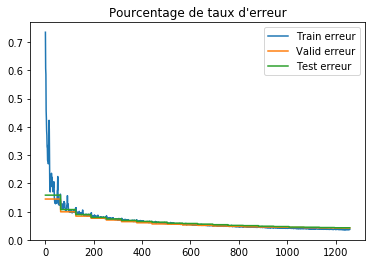

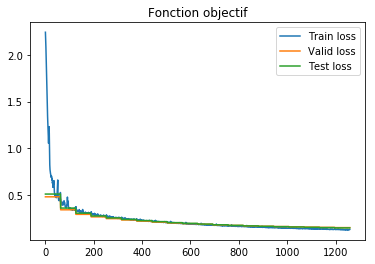

In [636]:
#ELoss,EErr,ETaux,VLoss,VErr,VTaux,TLoss,TErr,TTaux)
# load logs from file
logs_f=[]
with open("training.log","r") as f:
    while True:
        line = f.readline()
        logs_f.append(line)
        if not line:
            break

# Etendre(expand) array
def expandArray(t, n):
    t=t[:,None]
    temp=np.copy(t)
    for i in range(1,n):
        t=np.concatenate( ( t, temp) , axis=1 )
    return t.reshape(-1)

n=len(logs['ETaux'])/len(logs['VTaux'])
# Etendre(expand) les valeurs de validation taux pour chaque batch
vtaux=expandArray(np.array(logs['VTaux']), n)
# Etendre(expand) les valeurs de test taux pour chaque batch
ttaux=expandArray(np.array(logs['TTaux']), n)

plt.plot(logs['ETaux'], label='Train erreur')
plt.plot(vtaux, label='Valid erreur')
plt.plot(ttaux, label='Test erreur')
plt.title("Pourcentage de taux d'erreur")
plt.legend()
plt.show()

# Etendre(expand) les valeurs de validation loss pour chaque batch
vloss=expandArray(np.array(logs['VLoss']), n)
# Etendre(expand) les valeurs de test loss pour chaque batch
tloss=expandArray(np.array(logs['TLoss']), n)

plt.plot(logs['ELoss'], label='Train loss')
plt.plot(vloss, label='Valid loss')
plt.plot(tloss, label='Test loss')
plt.title('Fonction objectif')
plt.legend()
plt.show()

#### On va essayer d'obtenir un taux moins de 2% sur test data, avec beaucoup de neurones cachees.

In [59]:
# 784 neurones d'entrée, 1 couche cachee de 30 neurones, 10 neurones de sortie
reseauSizes=[784, 300, 10]
mu = 0.017
epoque=100
K_minibatch=30
lambda1=0.000002
lambda2=0.000002

print '\nReseauMLP Entrainement commence....'
# Faire l'entrainement
t1 = time.clock()
rmlp = ReseauMLP(reseauSizes,rect,softmax) 
logs5=rmlp.gradiantDescentMiniBatchVite(mnist_train_data, epoque, K_minibatch, mu, lambda1, lambda2,mnist_valid_data,mnist_test_data,display=True)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour entrainer le reseau',rmlp.sizes,' sur ', mnist_train_data.shape[0],' points de training data .'
print 'taux, num err, loss sur validation=',rmlp.evaluate(mnist_valid_data)
print 'taux, num err, loss sur test=',rmlp.evaluate(mnist_test_data)


ReseauMLP Entrainement commence....
Epoque 0 fini: 5350 erreurs sur 50000 train data, Taux d'erreur: 0.107, Loss: 0.378107193197
Epoque 0 fini: 942 erreurs sur 10000 validation data, Taux d'erreur: 0.0942, Loss: 0.342825372469
Epoque 0 fini: 1010 erreurs sur 10000 test data, Taux d'erreur: 0.101, Loss: 0.355985040085
Epoque 1 fini: 4392 erreurs sur 50000 train data, Taux d'erreur: 0.08784, Loss: 0.306073286667
Epoque 1 fini: 778 erreurs sur 10000 validation data, Taux d'erreur: 0.0778, Loss: 0.282189297395
Epoque 1 fini: 829 erreurs sur 10000 test data, Taux d'erreur: 0.0829, Loss: 0.291707255327
Epoque 2 fini: 3775 erreurs sur 50000 train data, Taux d'erreur: 0.0755, Loss: 0.265251029119
Epoque 2 fini: 699 erreurs sur 10000 validation data, Taux d'erreur: 0.0699, Loss: 0.248100433992
Epoque 2 fini: 732 erreurs sur 10000 test data, Taux d'erreur: 0.0732, Loss: 0.255921474929
Epoque 3 fini: 3324 erreurs sur 50000 train data, Taux d'erreur: 0.06648, Loss: 0.234693270398
Epoque 3 fini: 6

Epoque 28 fini: 241 erreurs sur 10000 test data, Taux d'erreur: 0.0241, Loss: 0.0813404055619
Epoque 29 fini: 604 erreurs sur 50000 train data, Taux d'erreur: 0.01208, Loss: 0.0485200081364
Epoque 29 fini: 239 erreurs sur 10000 validation data, Taux d'erreur: 0.0239, Loss: 0.081856387393
Epoque 29 fini: 239 erreurs sur 10000 test data, Taux d'erreur: 0.0239, Loss: 0.0803205950891
Epoque 30 fini: 583 erreurs sur 50000 train data, Taux d'erreur: 0.01166, Loss: 0.046781060769
Epoque 30 fini: 236 erreurs sur 10000 validation data, Taux d'erreur: 0.0236, Loss: 0.080969560139
Epoque 30 fini: 240 erreurs sur 10000 test data, Taux d'erreur: 0.024, Loss: 0.0793116955164
Epoque 31 fini: 549 erreurs sur 50000 train data, Taux d'erreur: 0.01098, Loss: 0.0451202530495
Epoque 31 fini: 234 erreurs sur 10000 validation data, Taux d'erreur: 0.0234, Loss: 0.0801925509466
Epoque 31 fini: 237 erreurs sur 10000 test data, Taux d'erreur: 0.0237, Loss: 0.0783625650268
Epoque 32 fini: 527 erreurs sur 50000 tr

Epoque 57 fini: 158 erreurs sur 50000 train data, Taux d'erreur: 0.00316, Loss: 0.0205234673797
Epoque 57 fini: 219 erreurs sur 10000 validation data, Taux d'erreur: 0.0219, Loss: 0.0708804708125
Epoque 57 fini: 210 erreurs sur 10000 test data, Taux d'erreur: 0.021, Loss: 0.06713289551
Epoque 58 fini: 153 erreurs sur 50000 train data, Taux d'erreur: 0.00306, Loss: 0.0200127945053
Epoque 58 fini: 216 erreurs sur 10000 validation data, Taux d'erreur: 0.0216, Loss: 0.0707937450042
Epoque 58 fini: 209 erreurs sur 10000 test data, Taux d'erreur: 0.0209, Loss: 0.0669672653791
Epoque 59 fini: 144 erreurs sur 50000 train data, Taux d'erreur: 0.00288, Loss: 0.0194871790891
Epoque 59 fini: 214 erreurs sur 10000 validation data, Taux d'erreur: 0.0214, Loss: 0.0706450869009
Epoque 59 fini: 208 erreurs sur 10000 test data, Taux d'erreur: 0.0208, Loss: 0.066816550693
Epoque 60 fini: 139 erreurs sur 50000 train data, Taux d'erreur: 0.00278, Loss: 0.019001155341
Epoque 60 fini: 215 erreurs sur 10000 v

Epoque 85 fini: 194 erreurs sur 10000 test data, Taux d'erreur: 0.0194, Loss: 0.0645799092862
Epoque 86 fini: 42 erreurs sur 50000 train data, Taux d'erreur: 0.00084, Loss: 0.0108063218168
Epoque 86 fini: 204 erreurs sur 10000 validation data, Taux d'erreur: 0.0204, Loss: 0.0693163357757
Epoque 86 fini: 194 erreurs sur 10000 test data, Taux d'erreur: 0.0194, Loss: 0.0645299310837
Epoque 87 fini: 40 erreurs sur 50000 train data, Taux d'erreur: 0.0008, Loss: 0.0106124151722
Epoque 87 fini: 204 erreurs sur 10000 validation data, Taux d'erreur: 0.0204, Loss: 0.0693012588022
Epoque 87 fini: 194 erreurs sur 10000 test data, Taux d'erreur: 0.0194, Loss: 0.0644504949119
Epoque 88 fini: 38 erreurs sur 50000 train data, Taux d'erreur: 0.00076, Loss: 0.0104131446235
Epoque 88 fini: 202 erreurs sur 10000 validation data, Taux d'erreur: 0.0202, Loss: 0.0693157231733
Epoque 88 fini: 194 erreurs sur 10000 test data, Taux d'erreur: 0.0194, Loss: 0.0644429350614
Epoque 89 fini: 36 erreurs sur 50000 tra

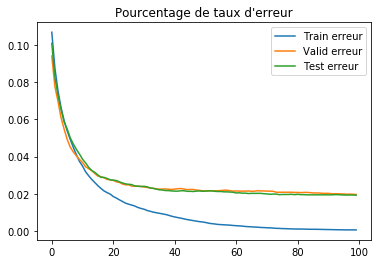

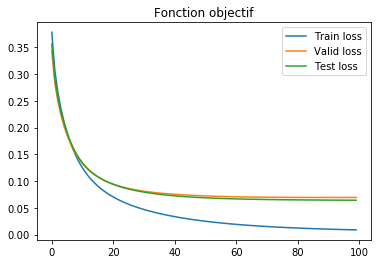

In [60]:

plt.plot(logs5['ETaux'], label='Train erreur')
plt.plot(logs5['VTaux'], label='Valid erreur')
plt.plot(logs5['TTaux'], label='Test erreur')
plt.title("Pourcentage de taux d'erreur")
plt.legend()
plt.show()

plt.plot(logs5['ELoss'], label='Train loss')
plt.plot(logs5['VLoss'], label='Valid loss')
plt.plot(logs5['TLoss'], label='Test loss')
plt.title('Fonction objectif')
plt.legend()
plt.show()

#### Résultat 3, en utilisant un réseau avec 2 couches cachées et les hyper-paramètres: 

reseauSizes=[784, 300, 10]

mu = 0.017

epoque=100

K_minibatch=30

lambda1=0.000002

lambda2=0.000002

Nous avons obtenu un taux d'erreur de test data = 1.92%.

* Epoque 99 fini: 196 erreurs sur 10000 validation data, Taux d'erreur: 0.0196, Loss: 0.0692606746457

* Epoque 99 fini: 192 erreurs sur 10000 test data, Taux d'erreur: 0.0192, Loss: 0.0641043638863

* Ca nous a pris  1754.653048  secondes pour entrainer le reseau [784, 300, 10]  sur  50000  points de training data .

* taux, num err, loss sur validation= (0.0196, 196, 0.069260674645677631)

* taux, num err, loss sur test= (0.0192, 192, 0.064104363886291968)

#### Nous essayons aussi un reseau avec 2 couche cachee.

In [61]:
# 784 neurones d'entrée, 1 couche cachee de 30 neurones, 10 neurones de sortie
reseauSizes=[784, 400, 100, 10]
mu = 0.017
epoque=100
K_minibatch=30
lambda1=0.000002
lambda2=0.000002

print '\nReseauMLP Entrainement commence....'
# Faire l'entrainement
t1 = time.clock()
rmlp = ReseauMLP(reseauSizes,rect,softmax) 
logs2=rmlp.gradiantDescentMiniBatchVite(mnist_train_data, epoque, K_minibatch, mu, lambda1, lambda2,mnist_valid_data,mnist_test_data,display=True)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour entrainer le reseau',rmlp.sizes,' sur ', mnist_train_data.shape[0],' points de training data .'
print 'taux, num err, loss sur validation=',rmlp.evaluate(mnist_valid_data)
print 'taux, num err, loss sur test=',rmlp.evaluate(mnist_test_data)


ReseauMLP Entrainement commence....
Epoque 0 fini: 5918 erreurs sur 50000 train data, Taux d'erreur: 0.11836, Loss: 0.400457596308
Epoque 0 fini: 1035 erreurs sur 10000 validation data, Taux d'erreur: 0.1035, Loss: 0.363197642676
Epoque 0 fini: 1131 erreurs sur 10000 test data, Taux d'erreur: 0.1131, Loss: 0.384912036126
Epoque 1 fini: 4467 erreurs sur 50000 train data, Taux d'erreur: 0.08934, Loss: 0.303381996466
Epoque 1 fini: 794 erreurs sur 10000 validation data, Taux d'erreur: 0.0794, Loss: 0.278271775056
Epoque 1 fini: 878 erreurs sur 10000 test data, Taux d'erreur: 0.0878, Loss: 0.296314048412
Epoque 2 fini: 3547 erreurs sur 50000 train data, Taux d'erreur: 0.07094, Loss: 0.243356973585
Epoque 2 fini: 645 erreurs sur 10000 validation data, Taux d'erreur: 0.0645, Loss: 0.226915163265
Epoque 2 fini: 703 erreurs sur 10000 test data, Taux d'erreur: 0.0703, Loss: 0.241176514311
Epoque 3 fini: 2898 erreurs sur 50000 train data, Taux d'erreur: 0.05796, Loss: 0.200688358923
Epoque 3 fi

Epoque 28 fini: 224 erreurs sur 10000 test data, Taux d'erreur: 0.0224, Loss: 0.0691251432666
Epoque 29 fini: 137 erreurs sur 50000 train data, Taux d'erreur: 0.00274, Loss: 0.0158091485491
Epoque 29 fini: 197 erreurs sur 10000 validation data, Taux d'erreur: 0.0197, Loss: 0.0738598240489
Epoque 29 fini: 223 erreurs sur 10000 test data, Taux d'erreur: 0.0223, Loss: 0.0688761846797
Epoque 30 fini: 127 erreurs sur 50000 train data, Taux d'erreur: 0.00254, Loss: 0.0147531870001
Epoque 30 fini: 196 erreurs sur 10000 validation data, Taux d'erreur: 0.0196, Loss: 0.0739603475528
Epoque 30 fini: 223 erreurs sur 10000 test data, Taux d'erreur: 0.0223, Loss: 0.0688992451151
Epoque 31 fini: 114 erreurs sur 50000 train data, Taux d'erreur: 0.00228, Loss: 0.013790533506
Epoque 31 fini: 195 erreurs sur 10000 validation data, Taux d'erreur: 0.0195, Loss: 0.0740897461801
Epoque 31 fini: 224 erreurs sur 10000 test data, Taux d'erreur: 0.0224, Loss: 0.0687582595551
Epoque 32 fini: 104 erreurs sur 50000

Epoque 57 fini: 177 erreurs sur 10000 validation data, Taux d'erreur: 0.0177, Loss: 0.0764968393812
Epoque 57 fini: 206 erreurs sur 10000 test data, Taux d'erreur: 0.0206, Loss: 0.0700519747148
Epoque 58 fini: 1 erreurs sur 50000 train data, Taux d'erreur: 2e-05, Loss: 0.00311589778548
Epoque 58 fini: 178 erreurs sur 10000 validation data, Taux d'erreur: 0.0178, Loss: 0.0765980676002
Epoque 58 fini: 206 erreurs sur 10000 test data, Taux d'erreur: 0.0206, Loss: 0.0701454666046
Epoque 59 fini: 1 erreurs sur 50000 train data, Taux d'erreur: 2e-05, Loss: 0.00301139191222
Epoque 59 fini: 178 erreurs sur 10000 validation data, Taux d'erreur: 0.0178, Loss: 0.0766699632368
Epoque 59 fini: 201 erreurs sur 10000 test data, Taux d'erreur: 0.0201, Loss: 0.0701360805566
Epoque 60 fini: 1 erreurs sur 50000 train data, Taux d'erreur: 2e-05, Loss: 0.00290788188521
Epoque 60 fini: 178 erreurs sur 10000 validation data, Taux d'erreur: 0.0178, Loss: 0.0767605146784
Epoque 60 fini: 201 erreurs sur 10000 t

Epoque 86 fini: 1 erreurs sur 50000 train data, Taux d'erreur: 2e-05, Loss: 0.00156234138119
Epoque 86 fini: 169 erreurs sur 10000 validation data, Taux d'erreur: 0.0169, Loss: 0.0782803355173
Epoque 86 fini: 194 erreurs sur 10000 test data, Taux d'erreur: 0.0194, Loss: 0.0720878397943
Epoque 87 fini: 1 erreurs sur 50000 train data, Taux d'erreur: 2e-05, Loss: 0.00153521443577
Epoque 87 fini: 170 erreurs sur 10000 validation data, Taux d'erreur: 0.017, Loss: 0.0783507215939
Epoque 87 fini: 193 erreurs sur 10000 test data, Taux d'erreur: 0.0193, Loss: 0.0721600213265
Epoque 88 fini: 1 erreurs sur 50000 train data, Taux d'erreur: 2e-05, Loss: 0.00151141638812
Epoque 88 fini: 171 erreurs sur 10000 validation data, Taux d'erreur: 0.0171, Loss: 0.0783747266963
Epoque 88 fini: 193 erreurs sur 10000 test data, Taux d'erreur: 0.0193, Loss: 0.0722088171101
Epoque 89 fini: 1 erreurs sur 50000 train data, Taux d'erreur: 2e-05, Loss: 0.00148671513003
Epoque 89 fini: 170 erreurs sur 10000 validatio

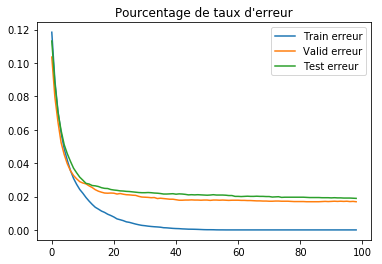

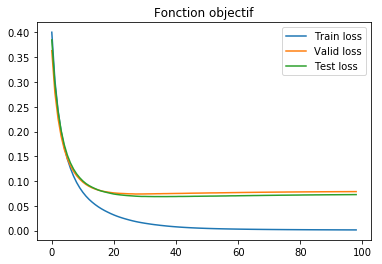

In [62]:

plt.plot(logs2['ETaux'], label='Train erreur')
plt.plot(logs2['VTaux'], label='Valid erreur')
plt.plot(logs2['TTaux'], label='Test erreur')
plt.title("Pourcentage de taux d'erreur")
plt.legend()
plt.show()

plt.plot(logs2['ELoss'], label='Train loss')
plt.plot(logs2['VLoss'], label='Valid loss')
plt.plot(logs2['TLoss'], label='Test loss')
plt.title('Fonction objectif')
plt.legend()
plt.show()

#### Résultat 4, en utilisant un réseau avec 2 couches cachées et les hyper-paramètres: 

reseauSizes=[784, 400, 100, 10]

mu = 0.017

epoque=100

K_minibatch=30

lambda1=0.000002

lambda2=0.000002

Nous avons obtenu un taux d'erreur de test data = 1.89%

* Epoque 98 fini: 1 erreurs sur 50000 train data, Taux d'erreur: 2e-05, Loss: 0.00130416815587

* Epoque 98 fini: 169 erreurs sur 10000 validation data, Taux d'erreur: 0.0169, Loss: 0.0786753355293

* Epoque 98 fini: 189 erreurs sur 10000 test data, Taux d'erreur: 0.0189, Loss: 0.0726294597247

* Ca nous a pris  2499.101472  secondes pour entrainer le reseau [784, 400, 100, 10]  sur  50000  points de training data .

* taux, num err, loss sur validation= (0.0169, 169, 0.078675335529338322)
* taux, num err, loss sur test= (0.0189, 189, 0.072629459724686457)
In [661]:


#### Conclusion:
* On constate que quand le taux d'apprentissage mu est trop large, le taux d'erreur subit une diminution rapide et ensuite il remonte après quelques époques.
* le K de mini batch ne doit pas être trop large, sinon le taux va rester fixe et ne descendra plus.
* le lambda de régularisation est aussi important pour obtenir un taux de test de moins de 2%, on a essayé les lambdas: 0.01, 0.0001, 0.0000001, 0.0000002. Quand lambda est trop petit, le taux d'erreur sur les données d'entrainement réduit jusqu'à 0%, mais le taux de validation et de test reste toujours à environ 2-3%. Enfin, pour notre modele, lambda=0.000002 est meilleur pour adapter avec les autres hyper-paramètres.
* En utilisant un réseau avec une couche caché de 300 neurones, ensuite un autre réseau avec 2 couches cachées, après en ajuster les hyper-paramètres plusiers fois, nous avons réussi à obtenir un taux d'erreur de moins de 2% sur les deux réseaux.